# set up

In [1]:
#Step 0 — Setup
import sys
from pathlib import Path

# Adjust if needed — point to your repo
REPO_DIR = Path("/Users/ywxiu/jasp-multimodal-rag")
sys.path.append(str(REPO_DIR))



In [2]:
# import data
import pandas as pd
import numpy as np

# Load the file
path = "../data/evaluation/retrieval_evaluation.csv"

df_eval = pd.read_csv(path)

# data description
print("Shape (rows, columns):", df_eval.shape)
print("data type:", df_eval.dtypes)


Shape (rows, columns): (1600, 9)
data type: QID                    int64
Question              object
Difficulty Level      object
Gold Standard Set     object
Retrieval Mode        object
Rank                   int64
Retrieved Doc         object
Relevance              int64
Notes                float64
dtype: object


# Evaluation
For each metric, we have 3 steps to answer different levels of questions:

step 1: What does the data look like?

step 2 :What is the average and how uncertain is it?

step 3: Are differences systematic and explainable?


#### A. Descriptive (one figure)
- distributional story (ECDF): ECDF curves per difficulty (two panels)

#### B. Summary (one table + one plot)
- interpretable summaries (median/tails):

    Report per (mode × difficulty): mean ± interval, median, 10th percentile (robustness),failure rate below a threshold

#### C. Inference (one primary model + robustness check)
- rigorous inference (model)+credibility via robustness check :

    Bayesian hierarchical Beta; 

    Frequentist mixed model with cluster bootstrap; 

    QID-level permutation test or bootstrap on QIDs.

## 1. Success@k (Binary Accuracy)

Success@k indicates whether the system retrieves at least one fully relevant document within the top k results. 

For each question and retrieval mode, Success@k is assigned a value of 1 if any item in the top k has a relevance label of 2; otherwise, it is assigned 0.


In [3]:
def compute_success_at_k(group):
    """
    Success@k = 1 if ANY fully relevant doc (Relevance == 2)
    appears within the top k retrieved results.
    Otherwise 0.
    """

    # Success if at least one doc in top-k is fully relevant
    success = 1 if (group["Relevance"] == 2).any() else 0

    return pd.Series({"Success@k": success})

results_success = (
    df_eval[df_eval["Difficulty Level"].isin(["easy", "difficult"])]
    .groupby(["QID","Question", "Difficulty Level", "Retrieval Mode"])
    .apply(compute_success_at_k)
    .reset_index()
)

print("Shape (rows, columns):", results_success.shape)
print (results_success)

Shape (rows, columns): (320, 5)
     QID                                           Question Difficulty Level  \
0      1       How do I open a dataset and view it in JASP?             easy   
1      1       How do I open a dataset and view it in JASP?             easy   
2      1       How do I open a dataset and view it in JASP?             easy   
3      1       How do I open a dataset and view it in JASP?             easy   
4      2  How can I save or export a JASP data file in J...             easy   
..   ...                                                ...              ...   
315  139  I’ve never used JASP before. Can you give me a...        difficult   
316  140  I’m evaluating a RAG system using two performa...        difficult   
317  140  I’m evaluating a RAG system using two performa...        difficult   
318  140  I’m evaluating a RAG system using two performa...        difficult   
319  140  I’m evaluating a RAG system using two performa...        difficult   

       

/var/folders/gc/n_hdb1rx3q934xsk94xgc7p80000gn/T/ipykernel_1204/2983224856.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_success_at_k)


In [4]:
# optional: save
out_path = f"results_success.csv"
results_success.to_csv(out_path, index=False)

print("Saved to:", out_path)

Saved to: results_success.csv


## Step 1 — Descriptive overview for Success@k (what the data look like)

In [5]:

# - shows raw success rates by Retrieval Mode × Difficulty
# - uncertainty as: (A) Frequentist Wilson CI and (B) Bayesian Beta-Binomial credible interval

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportion_confint
from scipy.stats import beta

# ----------------------------
# 0) Basic cleaning / checks
# ----------------------------
df = results_success.copy()

# If your column is literally named "Success@k", keep it.
# If it's "Success@k " etc, adjust here.
y_col = "Success@k"

# Ensure binary int
df[y_col] = df[y_col].astype(int)

# Optional: enforce consistent ordering (edit to your preferred order)
mode_order = ["BM25", "vector", "bm_vector_fusion", "bm_vector_fusion_rerank"]
diff_order = ["difficult", "easy"]

df["Retrieval Mode"] = pd.Categorical(df["Retrieval Mode"], categories=mode_order, ordered=True)
df["Difficulty Level"] = pd.Categorical(df["Difficulty Level"], categories=diff_order, ordered=True)

# ----------------------------
# 1) Aggregate counts
# ----------------------------
summary = (
    df.groupby(["Difficulty Level", "Retrieval Mode"], dropna=False)
      .agg(
          successes=(y_col, "sum"),
          n=(y_col, "count")
      )
      .reset_index()
)

summary["rate"] = summary["successes"] / summary["n"]

# ----------------------------
# 2A) Frequentist uncertainty: Wilson CI
# ----------------------------
ci_low, ci_high = proportion_confint(
    count=summary["successes"].astype(int),
    nobs=summary["n"].astype(int),
    alpha=0.05,
    method="wilson",
)
summary["wilson_low"] = ci_low
summary["wilson_high"] = ci_high

# ----------------------------
# 2B) Bayesian uncertainty: Beta posterior credible interval
# Prior: Beta(1,1) (uniform)  -> weak / neutral for a probability
# Posterior: Beta(1+successes, 1+(n-successes))
# ----------------------------
a0, b0 = 1.0, 1.0
a_post = a0 + summary["successes"].to_numpy()
b_post = b0 + (summary["n"] - summary["successes"]).to_numpy()

summary["bayes_mean"] = a_post / (a_post + b_post)
summary["bayes_low"] = beta.ppf(0.025, a_post, b_post)
summary["bayes_high"] = beta.ppf(0.975, a_post, b_post)

# ----------------------------
# Show the descriptive table
# ----------------------------
summary[[
    "Difficulty Level", "Retrieval Mode", "successes", "n",
    "rate", "wilson_low", "wilson_high",
    "bayes_mean", "bayes_low", "bayes_high"
]].sort_values(["Difficulty Level", "Retrieval Mode"])


/var/folders/gc/n_hdb1rx3q934xsk94xgc7p80000gn/T/ipykernel_1204/1078528063.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["Difficulty Level", "Retrieval Mode"], dropna=False)


,Difficulty Level,Retrieval Mode,successes,n,rate,wilson_low,wilson_high,bayes_mean,bayes_low,bayes_high
0,difficult,BM25,31,40,0.775,0.624969,0.876839,0.761905,0.623863,0.876368
1,difficult,vector,32,40,0.800,0.652427,0.895000,0.785714,0.651335,0.894392
2,difficult,bm_vector_fusion,34,40,0.850,0.709277,0.929388,0.833333,0.708270,0.928485
3,difficult,bm_vector_fusion_rerank,34,40,0.850,0.709277,0.929388,0.833333,0.708270,0.928485
4,easy,BM25,35,40,0.875,0.738879,0.945405,0.857143,0.737955,0.944343
5,easy,vector,36,40,0.900,0.769482,0.960420,0.880952,0.768685,0.959193
6,easy,bm_vector_fusion,35,40,0.875,0.738879,0.945405,0.857143,0.737955,0.944343
7,easy,bm_vector_fusion_rerank,38,40,0.950,0.834961,0.986179,0.928571,0.834667,0.984649


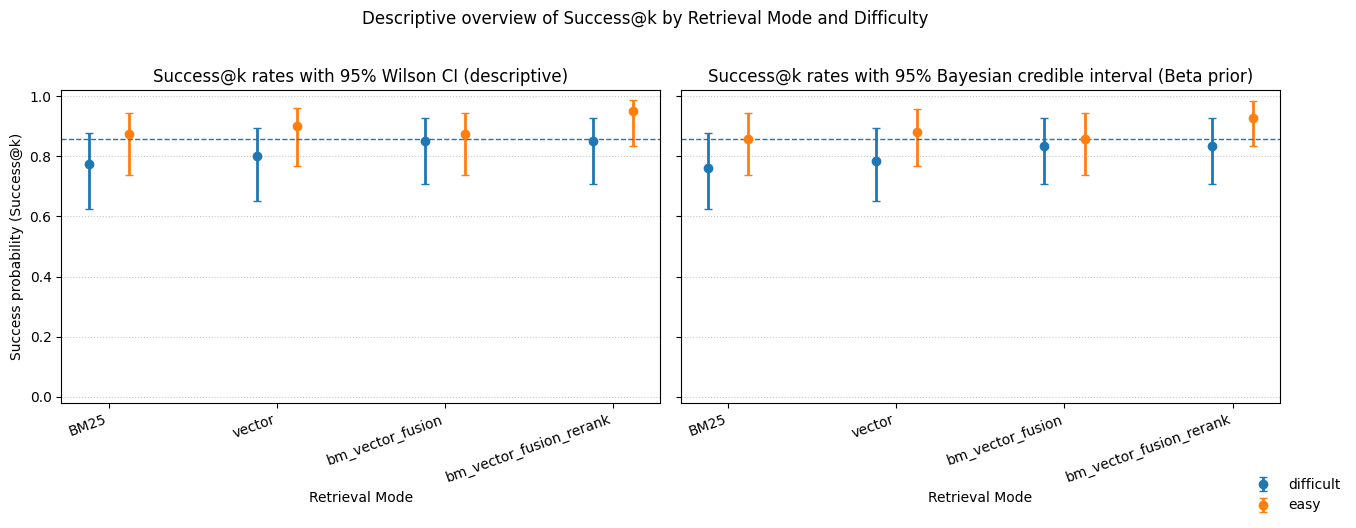

In [ ]:
# ----------------------------
# 3) Plot: two panels, same layout
#    - x: Retrieval Mode
#    - markers: Difficulty Level
# ----------------------------
overal_mean=results_success["Success@k"].mean()

fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

x = np.arange(len(mode_order))
offsets = {"difficult": -0.12, "easy": 0.12}

def plot_panel(ax, mean_col, low_col, high_col, title):
    for diff in diff_order:
        sub = summary[summary["Difficulty Level"] == diff].sort_values("Retrieval Mode")

        # align to mode_order index
        sub = sub.set_index("Retrieval Mode").reindex(mode_order).reset_index()

        y = sub[mean_col].to_numpy()
        yerr = np.vstack([y - sub[low_col].to_numpy(), sub[high_col].to_numpy() - y])

        ax.errorbar(
            x + offsets[diff],
            y,
            yerr=yerr,
            fmt="o",
            capsize=3,
            markersize=6,
            linewidth=0,      # no connecting line
            elinewidth=2,
            label=str(diff),
        )

    ax.set_xticks(x)
    ax.set_xticklabels(mode_order, rotation=20, ha="right")
    ax.set_ylim(-0.02, 1.02)
    ax.set_title(title)
    ax.set_xlabel("Retrieval Mode")
    ax.axhline(overal_mean, linewidth=1, linestyle="--")  # reference line:overal mean
    ax.grid(True, axis="y", linestyle=":", linewidth=0.8, alpha=0.7)

plot_panel(
    axes[0],
    mean_col="rate",
    low_col="wilson_low",
    high_col="wilson_high",
    title="Success@k rates with 95% Wilson CI (descriptive)"
)

plot_panel(
    axes[1],
    mean_col="bayes_mean",
    low_col="bayes_low",
    high_col="bayes_high",
    title="Success@k rates with 95% Bayesian credible interval (Beta prior)"
)

axes[0].set_ylabel("Success probability (Success@k)")

# One legend for both panels
handles, labels = axes[0].get_legend_handles_labels()

fig.legend(
    handles,
    labels,
    loc="center",
    bbox_to_anchor=(1, 0.05),  # tweak these two numbers if needed
    frameon=False,
)


fig.suptitle("Descriptive overview of Success@k by Retrieval Mode and Difficulty", y=1.02)
plt.tight_layout()
plt.show()



Success@k is systematically higher for easy queries across all methods.

Fusion and reranking methods show higher posterior success probabilities, especially for easy queries.

Bayesian and frequentist uncertainty estimates are consistent with each other.


## Step 2 — Bayesian Bernoulli Mixed-Effects Model (Success@k)

#### Model the probability of success as a function of:

Fixed effects (what we want to learn):

    Retrieval Mode (main effect)

    Difficulty Level (main effect)

    Mode × Difficulty (interaction)

Random effects:(Each QID appears multiple times (one per mode), so outcomes are correlated within query.)

    while accounting for repeated measures across QID.

#### Because Success@k ∈ {0,1}, use a Bernoulli likelihood with a logit link

    yi​∼Bernoulli(pi​),logit(pi​)=ηi​

#### Priors (weakly informative, practical)
    Use priors that regularize but don’t dominate:

        Fixed effects on log-odds scale: β∼N(0,1)

        Random effect SD: 𝜎QID∼HalfNormal(1)
            ​
        These are standard, stable defaults for logistic mixed models.

#### Decision rules (how to phrase conclusions)

        Strong evidence: P(A>B) ≥ 0.95

        Moderate evidence: 0.80–0.95

        Weak/inconclusive: 0.20–0.80

        Evidence for B: P(A>B) ≤ 0.05



In [ ]:

import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import patsy

# ----------------------------
# 0) Prep
# ----------------------------
df = results_success.copy()
y_col = "Success@k"
df[y_col] = df[y_col].astype(int)

# Keep consistent category order 
mode_order = ["BM25", "vector", "bm_vector_fusion", "bm_vector_fusion_rerank"]
diff_order = ["easy","difficult"]

df["Retrieval Mode"] = pd.Categorical(df["Retrieval Mode"], categories=mode_order, ordered=True)
df["Difficulty Level"] = pd.Categorical(df["Difficulty Level"], categories=diff_order, ordered=True)

# Design matrix (fixed effects)
rhs = "1 + C(Q('Retrieval Mode')) * C(Q('Difficulty Level'))"
X = patsy.dmatrix(rhs, df, return_type="dataframe")
X_np = X.to_numpy()

# Response
y = df[y_col].to_numpy()

# Random intercept index (QID)
qid_codes, qid_idx = np.unique(df["QID"], return_inverse=True)
n_qid = len(qid_codes)

print("N rows:", len(df))
print("N QID:", n_qid)
print("X shape:", X_np.shape, "| #fixed params:", X_np.shape[1])

# ----------------------------
# 1) Fit PyMC model
# ----------------------------
with pm.Model() as model_succ:

    # Random intercept for QID
    sigma_qid = pm.HalfNormal("sigma_qid", 1.0)
    z_qid = pm.Normal("z_qid", 0.0, 1.0, shape=n_qid)
    a_qid = pm.Deterministic("a_qid", sigma_qid * z_qid)

    # Fixed effects
    beta = pm.Normal("beta", 0.0, 1.0, shape=X_np.shape[1])

    # Linear predictor
    eta = a_qid[qid_idx] + pm.math.dot(X_np, beta)

    # Likelihood
    p = pm.Deterministic("p", pm.math.sigmoid(eta))
    pm.Bernoulli("y", p=p, observed=y)

    idata_succ = pm.sample(
        draws=2000,
        tune=2000,
        chains=4,
        target_accept=0.9,
        random_seed=42,
    )

# ----------------------------
# 2) Diagnostics summary
# ----------------------------
az.summary(idata_succ, var_names=["beta", "sigma_qid"], round_to=3)


Initializing NUTS using jitter+adapt_diag...


N rows: 320
N QID: 80
X shape: (320, 8) | #fixed params: 8


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_qid, z_qid, beta]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],2.649,0.508,1.755,3.664,0.007,0.005,5389.217,6202.204,1.000
beta[1],0.482,0.559,-0.600,1.496,0.006,0.006,7698.493,6040.152,1.000
beta[2],0.366,0.565,-0.717,1.399,0.006,0.006,8115.232,6220.685,1.000
beta[3],1.154,0.596,0.083,2.353,0.006,0.006,8452.804,6611.741,1.000
beta[4],-0.159,0.614,-1.255,1.063,0.009,0.006,4841.451,6002.182,1.001
beta[5],-0.178,0.681,-1.412,1.131,0.007,0.007,8361.596,6634.573,1.000
beta[6],0.409,0.687,-0.874,1.706,0.007,0.007,8818.109,5952.846,1.000
beta[7],-0.151,0.714,-1.466,1.223,0.008,0.007,9045.920,6183.026,1.000
sigma_qid,2.546,0.427,1.746,3.343,0.006,0.004,4802.405,5862.774,1.000


Everything looks clean:

    correct data dimensions

    good sampler behavior

    0 divergences

    r_hat ≈ 1.00

    large ESS

    sigma_qid meaningfully > 0 (mixed model is justified)


In [18]:
X.columns

Index(['Intercept', 'C(Q('Retrieval Mode'))[T.vector]',
       'C(Q('Retrieval Mode'))[T.bm_vector_fusion]',
       'C(Q('Retrieval Mode'))[T.bm_vector_fusion_rerank]',
       'C(Q('Difficulty Level'))[T.difficult]',
       'C(Q('Retrieval Mode'))[T.vector]:C(Q('Difficulty Level'))[T.difficult]',
       'C(Q('Retrieval Mode'))[T.bm_vector_fusion]:C(Q('Difficulty Level'))[T.difficult]',
       'C(Q('Retrieval Mode'))[T.bm_vector_fusion_rerank]:C(Q('Difficulty Level'))[T.difficult]'],
      dtype='object')

“Fixed effects were parameterized with BM25 on difficult queries as the reference level; interaction terms capture method-specific differences in the easy–difficult contrast. All substantive interpretations are based on posterior predicted probabilities and contrasts rather than raw regression coefficients.”

In [19]:
# Step 2.3 — Model-based predicted success probabilities by Mode × Difficulty (like your grid tables)

# Build a grid of conditions
grid = (
    df[["Retrieval Mode", "Difficulty Level"]]
    .drop_duplicates()
    .sort_values(["Difficulty Level", "Retrieval Mode"])
    .reset_index(drop=True)
)

Xg = patsy.dmatrix(rhs, grid, return_type="dataframe").to_numpy()

# Posterior samples for beta (shape: p × S)
post = idata_succ.posterior.stack(sample=("chain", "draw"))
beta_s = post["beta"].transpose("beta_dim_0", "sample").values  # (p, S)

# Predicted probabilities with random intercept set to 0 (population-average across QID)
eta_g = Xg @ beta_s                      # (conditions, S)
p_g = 1 / (1 + np.exp(-eta_g))           # (conditions, S)

hdi = az.hdi(p_g.T, hdi_prob=0.95)       # (conditions, 2)

grid_out = grid.copy()
grid_out["p_mean"] = p_g.mean(axis=1)
grid_out["p_hdi_low"] = hdi[:, 0]
grid_out["p_hdi_high"] = hdi[:, 1]

grid_out


/var/folders/gc/n_hdb1rx3q934xsk94xgc7p80000gn/T/ipykernel_1204/1550477063.py:21: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(p_g.T, hdi_prob=0.95)       # (conditions, 2)


,Retrieval Mode,Difficulty Level,p_mean,p_hdi_low,p_hdi_high
0,BM25,easy,0.927021,0.859116,0.982295
1,vector,easy,0.950217,0.889885,0.993391
2,bm_vector_fusion,easy,0.944699,0.877111,0.991812
3,bm_vector_fusion_rerank,easy,0.972913,0.935451,0.997191
4,BM25,difficult,0.912411,0.815943,0.984410
5,vector,difficult,0.930248,0.841486,0.992817
6,bm_vector_fusion,difficult,0.953723,0.887608,0.996316
7,bm_vector_fusion_rerank,difficult,0.962045,0.906897,0.997324


#### grid_out contains posterior predicted probabilities of success@k for each:
Retrieval Mode × Difficulty Level combination

Averaged over:query-level random effects, posterior uncertainty in all parameters

#### Each row answers:“If I randomly draw a new query from this population, what is the probability that this retrieval method succeeds@k?”

Given the model and data, there is 95% probability the true population-level success rate lies in this interval

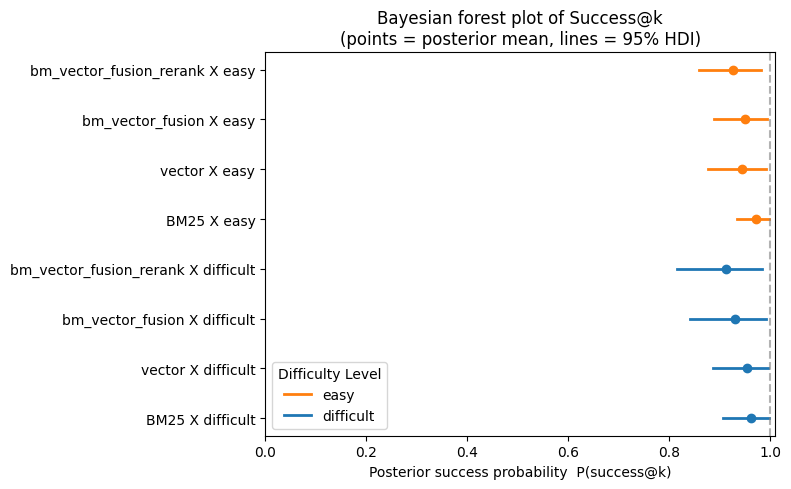

In [22]:
#Success@k forest plot (Bayesian, predictive)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Copy to avoid modifying original
df = grid_out.copy()

# Order methods (top → bottom)
method_order = [
    "BM25",
    "vector",
    "bm_vector_fusion",
    "bm_vector_fusion_rerank",
]

df["Retrieval Mode"] = pd.Categorical(
    df["Retrieval Mode"],
    categories=method_order,
    ordered=True,
)

# Sort for plotting
df = df.sort_values(["Difficulty Level", "Retrieval Mode"], ascending=[True, False])

# Create y positions
y = np.arange(len(df))

# Colors by difficulty
colors = {
    "difficult": "#1f77b4",
    "easy": "#ff7f0e",
}

fig, ax = plt.subplots(figsize=(8, 5))

# Plot each row
for i, row in df.iterrows():
    ax.plot(
        [row["p_hdi_low"], row["p_hdi_high"]],
        [y[i], y[i]],
        color=colors[row["Difficulty Level"]],
        lw=2,
    )
    ax.plot(
        row["p_mean"],
        y[i],
        "o",
        color=colors[row["Difficulty Level"]],
    )

# Y-axis labels
ax.set_yticks(y)

ax.set_yticklabels(
    [
        f"{m} X {d}"
        for m, d in zip(df["Retrieval Mode"], df["Difficulty Level"])
    ]
)

# Reference line (perfect success)
ax.axvline(1.0, color="gray", linestyle="--", alpha=0.6)

# Axis labels
ax.set_xlabel("Posterior success probability  P(success@k)")
ax.set_title("Bayesian forest plot of Success@k\n(points = posterior mean, lines = 95% HDI)")

# Legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color=colors["easy"], lw=2, label="easy"),
    Line2D([0], [0], color=colors["difficult"], lw=2, label="difficult"),
]
ax.legend(handles=legend_elements, title="Difficulty Level", loc="lower left")

# Limits & layout
ax.set_xlim(0, 1.01)
ax.invert_yaxis()
plt.tight_layout()

plt.show()


Reranking consistently achieves the highest posterior success probability, particularly on easy queries, while fusion methods outperform BM25 and vector retrieval on difficult queries.

In [23]:
# Step 2.4 — Pairwise contrasts (overall main effect of Retrieval Mode)
# Averaged over difficulty: 0.5*(easy diff + difficult diff)

from itertools import combinations

modes = mode_order[:]  # keep order

def p_draws(mode, diff):
    idx = grid_out.index[
        (grid_out["Retrieval Mode"] == mode) &
        (grid_out["Difficulty Level"] == diff)
    ][0]
    return p_g[idx, :]  # (S,)

rows = []
for a, b in combinations(modes, 2):
    delta = 0.5 * (
        (p_draws(a, "easy") - p_draws(b, "easy")) +
        (p_draws(a, "difficult") - p_draws(b, "difficult"))
    )
    h = az.hdi(delta, hdi_prob=0.95)
    rows.append({
        "A": a,
        "B": b,
        "Delta_p_mean (A-B)": float(delta.mean()),
        "HDI_low": float(h[0]),
        "HDI_high": float(h[1]),
        "P(A>B)": float((delta > 0).mean()),
    })

pairwise_overall = pd.DataFrame(rows).sort_values("Delta_p_mean (A-B)", ascending=False)
pairwise_overall


,A,B,Delta_p_mean (A-B),HDI_low,HDI_high,P(A>B)
3,vector,bm_vector_fusion,-0.008979,-0.075243,0.049674,0.377625
5,bm_vector_fusion,bm_vector_fusion_rerank,-0.018268,-0.072325,0.030482,0.206625
0,BM25,vector,-0.020517,-0.086719,0.045618,0.236125
4,vector,bm_vector_fusion_rerank,-0.027246,-0.088526,0.024919,0.132625
1,BM25,bm_vector_fusion,-0.029495,-0.095888,0.031331,0.144750
2,BM25,bm_vector_fusion_rerank,-0.047763,-0.112455,0.002427,0.026750


Each row compares two retrieval methods:

A vs B:

    Delta_p_mean (A−B) = posterior mean difference in success probability

    HDI_low / HDI_high = 95% Highest Density Interval for the difference

    P(A>B) = posterior probability that A is better than B

This is Bayesian pairwise inference, not a hypothesis test.

For any row:“The estimated difference in success@k between A and B is Δ, with a 95% credible interval [low, high], and the probability that A outperforms B is P.”

In [24]:
# Step 2.5 — Pairwise contrasts within each difficulty

rows = []
for diff in ["easy", "difficult"]:
    for a, b in combinations(modes, 2):
        delta = p_draws(a, diff) - p_draws(b, diff)
        h = az.hdi(delta, hdi_prob=0.95)
        rows.append({
            "Difficulty": diff,
            "A": a,
            "B": b,
            "Delta_p_mean (A-B)": float(delta.mean()),
            "HDI_low": float(h[0]),
            "HDI_high": float(h[1]),
            "P(A>B)": float((delta > 0).mean()),
        })

pairwise_by_diff = (
    pd.DataFrame(rows)
      .sort_values(["Difficulty", "Delta_p_mean (A-B)"], ascending=[True, False])
      .reset_index(drop=True)
)

pairwise_by_diff


,Difficulty,A,B,Delta_p_mean (A-B),HDI_low,HDI_high,P(A>B)
0,difficult,bm_vector_fusion,bm_vector_fusion_rerank,-0.008322,-0.086262,0.054464,0.382250
1,difficult,BM25,vector,-0.017837,-0.116136,0.073723,0.313500
2,difficult,vector,bm_vector_fusion,-0.023475,-0.114985,0.062194,0.262750
3,difficult,vector,bm_vector_fusion_rerank,-0.031797,-0.127606,0.038817,0.185000
4,difficult,BM25,bm_vector_fusion,-0.041312,-0.137685,0.034429,0.114000
5,difficult,BM25,bm_vector_fusion_rerank,-0.049634,-0.140194,0.023824,0.066375
6,easy,vector,bm_vector_fusion,0.005518,-0.065794,0.083299,0.566875
7,easy,BM25,bm_vector_fusion,-0.017678,-0.082874,0.056281,0.260125
8,easy,vector,bm_vector_fusion_rerank,-0.022696,-0.088508,0.031388,0.179625
9,easy,BM25,vector,-0.023196,-0.092595,0.041810,0.194125


How to read pairwise_by_diff

Each row answers:Within a given difficulty level, how much better is method A than method B in terms of success@k?

“Using a Bayesian Bernoulli mixed-effects model with query-level random effects, we found no strong evidence for main effects of retrieval mode or difficulty level on success@k, nor for interaction effects between them. Posterior differences between methods were small, with wide credible intervals and posterior probabilities close to chance, indicating that success@k is largely insensitive to retrieval strategy in this setting.”

| Metric        | Data type                                     | Statistical consequence   |
| ------------- | --------------------------------------------- | ------------------------- |
| **nDCG@k**    | Continuous on ([0,1]) with **many 0s and 1s** | Requires mixture modeling |
| **success@k** | **Binary** (0/1)                              | Naturally Bernoulli       |


## 2. nDCG@k(Ranking Quality) 


nDCG@k (Normalized Discounted Cumulative Gain) evaluates the ranking quality of the retrieved documents based on the graded relevance labels assigned during annotation. 

The metric accounts for both relevance and ranking position, which rewards systems that not only retrieve relevant documents but also order them appropriately, with the strongest emphasis placed on highly relevant items appearing early.

 nDCG@k is normalized between 0 and 1, where 1 represents a perfect ranking that matches the ideal ordering, and 0 represents the poorest possible ranking given the relevance configuration. 


In [25]:
import numpy as np
import pandas as pd

def compute_ndcg_variable_k(group):
    """
    nDCG@k with variable k:
      k = number of retrieved docs in this (QID, Difficulty, Mode) group.
    Uses graded relevance in column 'Relevance' (e.g. 0,1,2).
    """

    # sort by rank just in case
    g = group.sort_values("Rank")

    # relevance scores and ranks as arrays
    rel = g["Relevance"].to_numpy(dtype=float)
    ranks = g["Rank"].to_numpy(dtype=float)

    if len(rel) == 0:
        return pd.Series({"nDCG@k": np.nan})

    # ------- DCG -------
    # Compute DCG@k (Discounted Cumulative Gain): 
    # DCG assigns a gain to each retrieved document depending on its relevance
    # So relevant results at the top give much more DCG than at the bottom.

    gains = (2 ** rel) - 1
    dcg = np.sum(gains / np.log2(ranks + 1.0))

    # ------- IDCG (ideal DCG) -------
    # Compute IDCG@k (Ideal DCG):
    # IDCG is the maximum possible DCG for the same results if they were perfectly sorted.
    # To compute this:Sort the relevance values from highest → lowest;Compute DCG on this perfect ordering
    # IDCG represents the best case score.

    ideal_rel = np.sort(rel)[::-1]                     # best ranking
    ideal_ranks = np.arange(1, len(ideal_rel) + 1)
    ideal_gains = (2 ** ideal_rel) - 1
    idcg = np.sum(ideal_gains / np.log2(ideal_ranks + 1.0))

    # -------Normalise: nDCG = DCG / IDCG-------
    # Range:1.0 = perfect ranking; 0.0 = no useful ranking signal;
    # Always between 0 and 1
    # This allows comparing across different questions, datasets, and retrieval modes.
    if idcg == 0:
        ndcg = 0.0
    else:
        ndcg = dcg / idcg

    return pd.Series({"nDCG@k": ndcg})

results_ndcg = (
      df_eval
      .groupby(["QID", "Question","Difficulty Level", "Retrieval Mode"])
      .apply(compute_ndcg_variable_k)
      .reset_index()
)

results_ndcg


/var/folders/gc/n_hdb1rx3q934xsk94xgc7p80000gn/T/ipykernel_1204/3255638223.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_ndcg_variable_k)


,QID,Question,Difficulty Level,Retrieval Mode,nDCG@k
0,1,How do I open a dataset and view it in JASP?,easy,BM25,0.850345
1,1,How do I open a dataset and view it in JASP?,easy,bm_vector_fusion,0.707579
2,1,How do I open a dataset and view it in JASP?,easy,bm_vector_fusion_rerank,1.000000
3,1,How do I open a dataset and view it in JASP?,easy,vector,0.912878
4,2,How can I save or export a JASP data file in J...,easy,BM25,0.892689
...,...,...,...,...,...
315,139,I’ve never used JASP before. Can you give me a...,difficult,vector,0.864220
316,140,I’m evaluating a RAG system using two performa...,difficult,BM25,0.386853
317,140,I’m evaluating a RAG system using two performa...,difficult,bm_vector_fusion,1.000000
318,140,I’m evaluating a RAG system using two performa...,difficult,bm_vector_fusion_rerank,0.946902


In [26]:
# optional: save
out_path = f"results_ndcg.csv"
results_ndcg.to_csv(out_path, index=False)

print("Saved to:", out_path)

Saved to: results_ndcg.csv


## Step 1 — Descriptive distributional visualization
(Violin plots + raw points)
Question answered : What do the query-level nDCG@k values actually look like?

/var/folders/gc/n_hdb1rx3q934xsk94xgc7p80000gn/T/ipykernel_1204/474750596.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["Difficulty Level", "Retrieval Mode"])


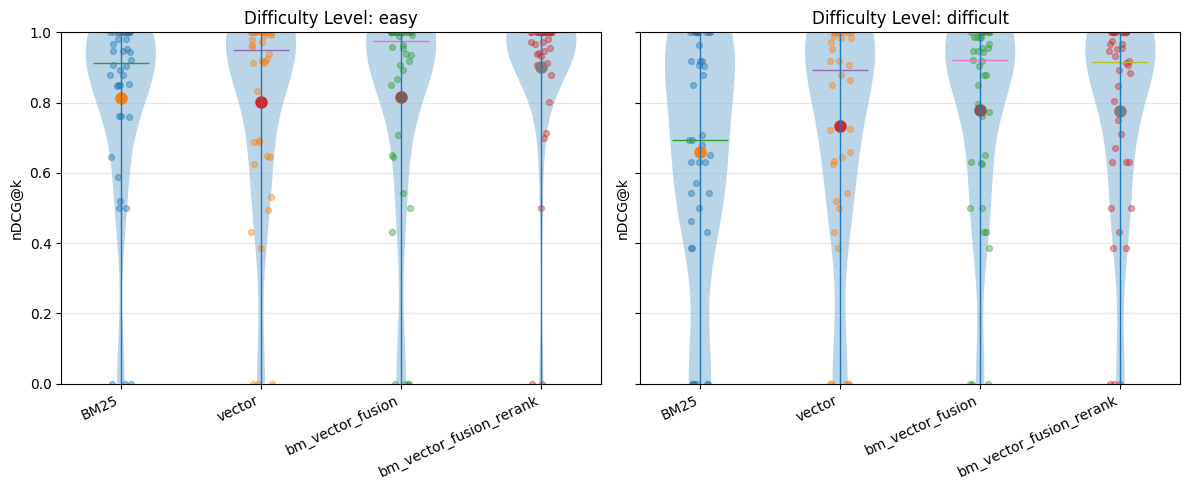

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = results_ndcg.dropna(subset=["nDCG@k"]).copy()

df["Retrieval Mode"] = df["Retrieval Mode"].astype(str)
df["Difficulty Level"] = df["Difficulty Level"].astype(str)

mode_order = [
    "BM25",
    "vector",
    "bm_vector_fusion",
    "bm_vector_fusion_rerank",
]

df["Retrieval Mode"] = pd.Categorical(
    df["Retrieval Mode"], categories=mode_order, ordered=True
)

summary = (
    df.groupby(["Difficulty Level", "Retrieval Mode"])
      .agg(
          mean=("nDCG@k", "mean"),
          median=("nDCG@k", "median"),
          min=("nDCG@k", "min"),
          max=("nDCG@k", "max"),
      )
      .reset_index()
)
difficulties = df["Difficulty Level"].unique()

fig, axes = plt.subplots(
    1, len(difficulties),
    figsize=(6 * len(difficulties), 5),
    sharey=True
)

if len(difficulties) == 1:
    axes = [axes]

for ax, diff in zip(axes, difficulties):
    sub = df[df["Difficulty Level"] == diff]
    sub_sum = summary[summary["Difficulty Level"] == diff]

    modes = sub["Retrieval Mode"].cat.categories
    x = np.arange(len(modes))

    # ---- violin plot ----
    data = [
        sub[sub["Retrieval Mode"] == m]["nDCG@k"].values
        for m in modes
    ]

    parts = ax.violinplot(
        data,
        positions=x,
        showmeans=False,
        showmedians=False,
        showextrema=False
    )

    # ---- jittered points ----
    for i, m in enumerate(modes):
        y = sub[sub["Retrieval Mode"] == m]["nDCG@k"].values
        jitter = np.random.uniform(-0.08, 0.08, size=len(y))
        ax.scatter(
            np.full_like(y, x[i]) + jitter,
            y,
            alpha=0.4,
            s=18
        )

    # ---- summary statistics ----
    for i, m in enumerate(modes):
        row = sub_sum[sub_sum["Retrieval Mode"] == m].iloc[0]

        # mean
        ax.plot(x[i], row["mean"], marker="o", markersize=8)
        # median
        ax.plot(x[i], row["median"], marker="_", markersize=40, linewidth=5)
        # min-max
        ax.vlines(
            x[i],
            row["min"],
            row["max"],
            linewidth=1
        )

    ax.set_title(f"Difficulty Level: {diff}")
    ax.set_xticks(x)
    ax.set_xticklabels(modes, rotation=25, ha="right")
    ax.set_ylim(0, 1)
    ax.set_ylabel("nDCG@k")
    ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()


#### For each difficulty × mode:
    Violin width → density of nDCG@k values
    Dots → individual queries
    Circle (●) → mean nDCG@k
    Thick bar (—) → median nDCG@k
    Vertical line → min–max range

#### This immediately shows:
    skewness (mean ≠ median)
    ceiling effects (mass near 1)
    stability (tight vs wide distributions)
    whether differences are driven by few queries or systematic shifts

#### Easy questions (left panel) -Overall pattern:

All methods perform very well on easy queries.
Distributions are top-heavy, with most mass between 0.85–1.0.
Medians are consistently higher than means, indicating left-skew driven by a few low-performing queries.

For easy questions, advanced fusion and reranking primarily reduce variance and eliminate failures, rather than dramatically increasing already-high performance.

#### Difficult questions (right panel)-Overall pattern

Performance drops noticeably across all methods.
Distributions become wider and more symmetric
Mean and median are closer → less skew

For difficult queries, vector,fusion and reranking provide substantial gains in ranking quality compared to bm25, not just variance reduction. The improvement is systematic across queries.


#### empirical cumulative distribution function (ECDF)

An ECDF curve answers:

For a given method, what fraction of queries achieve at most a given nDCG@k value?

Equivalently:

Curves more to the right / lower are better

Vertical gaps = differences in failure rate

Horizontal gaps = differences in ranking quality

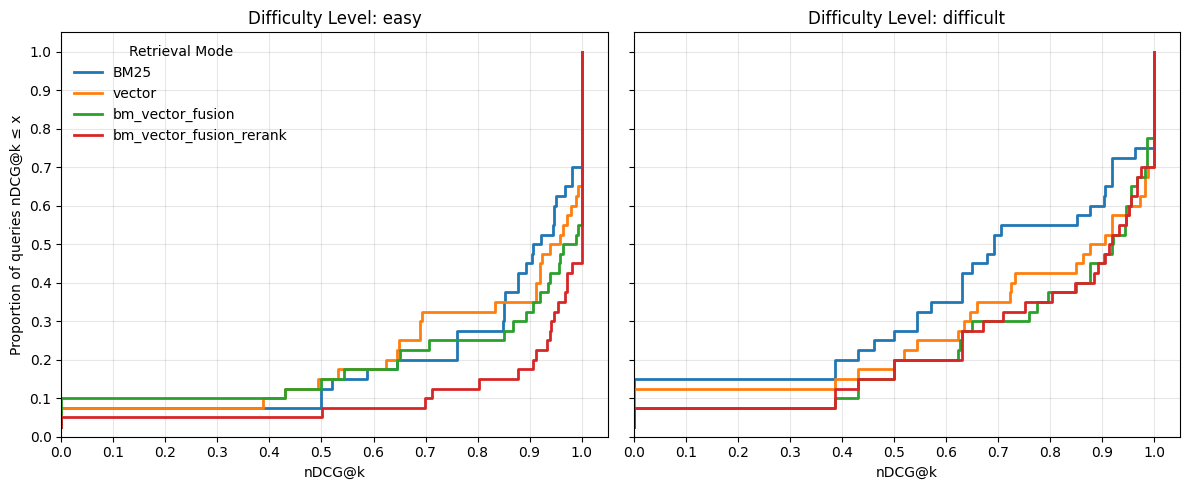

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = results_ndcg.dropna(subset=["nDCG@k"]).copy()

df["Retrieval Mode"] = df["Retrieval Mode"].astype(str)
df["Difficulty Level"] = df["Difficulty Level"].astype(str)
mode_order = ["BM25","vector", "bm_vector_fusion", "bm_vector_fusion_rerank"]
mode_order = [m for m in mode_order if m in df["Retrieval Mode"].unique()]

def ecdf(x):
    x = np.sort(np.asarray(x))
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y

difficulties = ["easy","difficult"]

fig, axes = plt.subplots(
    1, len(difficulties),
    figsize=(6 * len(difficulties), 5),
    sharey=True
)

if len(difficulties) == 1:
    axes = [axes]

for ax, diff in zip(axes, difficulties):
    sub = df[df["Difficulty Level"] == diff]

    modes = mode_order if len(mode_order) > 0 else sorted(sub["Retrieval Mode"].unique())

    for mode in modes:
        x = sub[sub["Retrieval Mode"] == mode]["nDCG@k"].values
        if len(x) == 0:
            continue

        xs, ys = ecdf(x)
        ax.step(xs, ys, where="post", linewidth=2, label=mode)

    ax.set_title(f"Difficulty Level: {diff}")
    ax.set_xlabel("nDCG@k")
    ax.set_xlim(0, 1.05)
    ax.set_xticks(np.arange(0, 1.01, 0.1))
    ax.set_ylim(0, 1.05)
    ax.set_yticks(np.arange(0, 1.01, 0.1))
    ax.grid(alpha=0.3)

axes[0].set_ylabel("Proportion of queries nDCG@k ≤ x")
axes[0].legend(title="Retrieval Mode", frameon=False)

plt.tight_layout()
plt.show()


x-axis (nDCG@k) is the ranking quality, from 0 (worst) to 1 (perfect).

y-axis (Proportion of queries) is the raction of queries that have nDCG@k ≤ x

At any point (x, y):y% of queries have nDCG@k less than or equal to x

A better retrieval method has its curve more to the right and/or lower.
If one curve is everywhere below another, it dominates it.
    - Lower curve → fewer low-scoring (bad) queries
    - Right-shift → more queries achieve higher nDCG

For easy questions, all methods perform well, and differences are small. More advanced methods provide slight improvements, but gains are limited because performance is already near the ceiling.

For difficult questions, 
- Low nDCG region (0–0.4): a larger fraction of difficult queries fail badly with BM25 and vector than with fusion-based methods.
- Middle region (0.4–0.7): Curves are close but not identical, BM25 stays above others (worse), Fusion/rerank are slightly lower Fusion-based methods reduce the number of moderately bad rankings.
- High nDCG region (0.8–1.0):All curves approach 1, Fusion and rerank reach high values slightly earlier.Fusion-based methods help more queries achieve very high ranking quality.

note: The curves are close. This means: Differences exist. But they are not dramatic.No method completely dominates the others.

ECDF makes it clear that:
Fusion and rerank slightly reduce low-quality outcomes, slightly increase high-quality outcomes

But: many queries behave similarly across methods. some queries are hard no matter what


In [30]:
import pandas as pd

quantiles = [0.10, 0.25, 0.50, 0.75, 0.90]

quantile_table = (
    df.groupby(["Difficulty Level", "Retrieval Mode"])["nDCG@k"]
      .quantile(quantiles)
      .unstack(level=-1)
      .reset_index()
)

# Rename columns nicely
quantile_table.columns.name = None
quantile_table = quantile_table.rename(
    columns={
        0.10: "Q10: worst 10% of queries",
        0.25: "Q25: lower quartile",
        0.50: "Median: typical query",
        0.75: "Q75: upper quartile",
        0.90: "Q90: near-best queries",
    }
)

quantile_cols = [
    "Q10: worst 10% of queries",
    "Q25: lower quartile",
    "Median: typical query",
    "Q75: upper quartile",
    "Q90: near-best queries",
]

quantile_table[quantile_cols] = quantile_table[quantile_cols].round(3)


difficulty_order = ["easy", "difficult"]

mode_order = [
    "BM25",
    "vector",
    "bm_vector_fusion",
    "bm_vector_fusion_rerank",
]
quantile_table["Difficulty Level"] = pd.Categorical(
    quantile_table["Difficulty Level"],
    categories=difficulty_order,
    ordered=True
)

quantile_table["Retrieval Mode"] = pd.Categorical(
    quantile_table["Retrieval Mode"],
    categories=mode_order,
    ordered=True
)


quantile_table = quantile_table.sort_values(
    ["Difficulty Level", "Retrieval Mode"]
).reset_index(drop=True)

quantile_table 

,Difficulty Level,Retrieval Mode,Q10: worst 10% of queries,Q25: lower quartile,Median: typical query,Q75: upper quartile,Q90: near-best queries
0,easy,BM25,0.500,0.761,0.914,1.000,1.0
1,easy,vector,0.426,0.679,0.949,1.000,1.0
2,easy,bm_vector_fusion,0.388,0.815,0.977,1.000,1.0
3,easy,bm_vector_fusion_rerank,0.711,0.938,1.000,1.000,1.0
4,difficult,BM25,0.000,0.491,0.693,0.973,1.0
5,difficult,vector,0.000,0.604,0.892,1.000,1.0
6,difficult,bm_vector_fusion,0.426,0.630,0.921,0.987,1.0
7,difficult,bm_vector_fusion_rerank,0.387,0.631,0.916,1.000,1.0


intepreting examples:

For easy queries using BM25, the worst 10% of queries achieve an nDCG@k of 0.45 or lower, indicating that a small subset is ranked poorly.

For difficult queries retrieved using vector search, the median nDCG@k is 0.877, meaning that half of the difficult queries achieve ranking quality above this level.

## Step 2 — Mean estimation with uncertainty
(Frequentist + Bayesian intervals)
Question answered :What is the average performance, and how uncertain is it?

 Frequentist bootstrap confidence intervals and Bayesian bootstrap credible intervals were visualized side-by-side for direct comparison across retrieval modes and difficulty levels. Both approaches use resampling techniques but differ fundamentally in interpretation: frequentist intervals describe long-run coverage properties, whereas Bayesian intervals express posterior uncertainty about the parameter of interest. Presenting both provides a comprehensive assessment of retrieval performance uncertainty in the absence of strong distributional assumptions. 

Frequentist uncertainty around the mean nDCG@k was estimated using non-parametric bootstrap confidence intervals. For each retrieval mode and difficulty level, bootstrap samples were generated by resampling the observed query-level nDCG@k values with replacement. The mean nDCG@k was recalculated for each bootstrap sample, producing an empirical sampling distribution of the mean. Two-sided 95% confidence intervals were obtained using the percentile method.

These bootstrap confidence intervals quantify sampling variability and are interpreted in a frequentist sense: under repeated sampling from the same population of queries, 95% of such intervals would be expected to contain the true population mean nDCG@k.

In addition to frequentist inference, Bayesian uncertainty was quantified using the Bayesian bootstrap. This approach provides a non-parametric Bayesian posterior distribution for the mean nDCG@k without requiring specification of a parametric likelihood or prior distribution over the metric. For each retrieval mode and difficulty level, Dirichlet-distributed weights with parameters 
α=1 were assigned to the observed nDCG@k values, and weighted means were computed across many posterior draws. The resulting distribution represents the posterior uncertainty of the mean under an exchangeability assumption.

From this posterior distribution, 95% Bayesian credible intervals were derived using the corresponding quantiles. These intervals are interpreted probabilistically: given the observed data, there is a 95% posterior probability that the true mean nDCG@k lies within the reported interval.



Frequentist summary (bootstrap 95% CI):
            Retrieval Mode Difficulty Level   n  ndcg_mean    ci_low   ci_high
0                     BM25        difficult  40   0.660101  0.552145  0.762163
2         bm_vector_fusion        difficult  40   0.778180  0.684847  0.862811
4  bm_vector_fusion_rerank        difficult  40   0.777421  0.679899  0.862461
6                   vector        difficult  40   0.733568  0.627475  0.832101
1                     BM25             easy  40   0.813351  0.722463  0.891136
3         bm_vector_fusion             easy  40   0.816273  0.714564  0.906780
5  bm_vector_fusion_rerank             easy  40   0.900456  0.821546  0.961676
7                   vector             easy  40   0.801234  0.705614  0.884047

Bayesian summary (Bayesian bootstrap 95% credible interval):
            Retrieval Mode Difficulty Level   n  ndcg_mean    cr_low   cr_high
0                     BM25        difficult  40   0.660101  0.549619  0.756776
2         bm_vector_fusion   

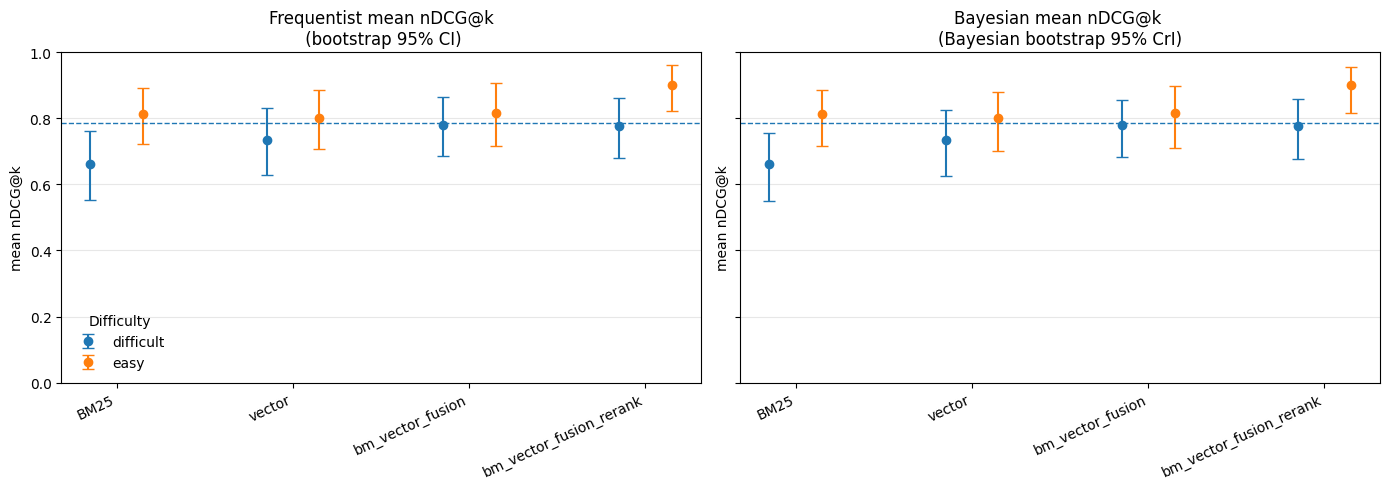

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 1) Frequentist + Bayesian summaries for mean(nDCG@k)
# -----------------------------
def bootstrap_mean_ci(x, n_boot=20000, alpha=0.05, rng=None):
    """
    Frequentist bootstrap CI for the mean.
    Returns (mean, ci_low, ci_high).
    """
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    n = len(x)
    if n == 0:
        return np.nan, np.nan, np.nan

    if rng is None:
        rng = np.random.default_rng(0)

    boots = rng.choice(x, size=(n_boot, n), replace=True).mean(axis=1)
    lo = np.quantile(boots, alpha / 2)
    hi = np.quantile(boots, 1 - alpha / 2)
    return x.mean(), lo, hi


def bayesian_bootstrap_mean_ci(x, n_boot=20000, alpha=0.05, rng=None):
    """
    Bayesian bootstrap CI (credible interval) for the mean.
    Uses weights ~ Dirichlet(1,...,1), posterior over the mean is the distribution
    of weighted means.
    Returns (mean, ci_low, ci_high) where 'mean' is the sample mean.
    """
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    n = len(x)
    if n == 0:
        return np.nan, np.nan, np.nan

    if rng is None:
        rng = np.random.default_rng(0)

    # Dirichlet weights for each bootstrap draw
    w = rng.dirichlet(alpha=np.ones(n), size=n_boot)   # (n_boot, n)
    post_means = (w * x).sum(axis=1)
    lo = np.quantile(post_means, alpha / 2)
    hi = np.quantile(post_means, 1 - alpha / 2)
    return x.mean(), lo, hi


def summarize_ndcg(results_ndcg, n_boot=20000, alpha=0.05, seed=0):
    """
    Build two summary tables:
      - frequentist bootstrap CI for mean nDCG@k
      - bayesian bootstrap credible interval for mean nDCG@k
    Grouping: Retrieval Mode × Difficulty Level
    """
    rng = np.random.default_rng(seed)

    grp_cols = ["Retrieval Mode", "Difficulty Level"]
    g = results_ndcg.dropna(subset=["nDCG@k"]).groupby(grp_cols, dropna=False)

    rows_f = []
    rows_b = []

    for key, sub in g:
        mode, diff = key
        x = sub["nDCG@k"].to_numpy(dtype=float)

        m_f, lo_f, hi_f = bootstrap_mean_ci(x, n_boot=n_boot, alpha=alpha, rng=rng)
        m_b, lo_b, hi_b = bayesian_bootstrap_mean_ci(x, n_boot=n_boot, alpha=alpha, rng=rng)

        rows_f.append({
            "Retrieval Mode": mode,
            "Difficulty Level": diff,
            "n": len(x),
            "ndcg_mean": m_f,
            "ci_low": lo_f,
            "ci_high": hi_f
        })

        rows_b.append({
            "Retrieval Mode": mode,
            "Difficulty Level": diff,
            "n": len(x),
            "ndcg_mean": m_b,          # same point estimate (sample mean)
            "cr_low": lo_b,
            "cr_high": hi_b
        })

    freq = pd.DataFrame(rows_f)
    baye = pd.DataFrame(rows_b)
    return freq, baye


freq_sum, baye_sum = summarize_ndcg(results_ndcg, n_boot=20000, alpha=0.05, seed=42)

print("Frequentist summary (bootstrap 95% CI):")
print(freq_sum.sort_values(["Difficulty Level", "Retrieval Mode"]))

print("\nBayesian summary (Bayesian bootstrap 95% credible interval):")
print(baye_sum.sort_values(["Difficulty Level", "Retrieval Mode"]))


# -----------------------------
# 2) Side-by-side plots
# -----------------------------

overal_mean=results_ndcg["nDCG@k"].mean()

def plot_side_by_side(freq_sum, baye_sum, mode_order=None, y_ref=None):
    """
    Two panels: Frequentist CI vs Bayesian credible interval.
    X = Retrieval Mode, markers = Difficulty Level
    """
    if mode_order is None:
        # default: keep sorted unique modes
        mode_order = sorted(pd.unique(freq_sum["Retrieval Mode"].astype(str)))

    # ensure categorical ordering
    for df in (freq_sum, baye_sum):
        df["Retrieval Mode"] = pd.Categorical(df["Retrieval Mode"], categories=mode_order, ordered=True)
        df.sort_values(["Difficulty Level", "Retrieval Mode"], inplace=True)

    diffs = sorted(pd.unique(freq_sum["Difficulty Level"].astype(str)))
    x = np.arange(len(mode_order))
    offsets = np.linspace(-0.15, 0.15, len(diffs)) if len(diffs) > 1 else np.array([0.0])

    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

    panels = [
        ("Frequentist mean nDCG@k\n (bootstrap 95% CI)", freq_sum, "ci_low", "ci_high"),
        ("Bayesian mean nDCG@k \n(Bayesian bootstrap 95% CrI)", baye_sum, "cr_low", "cr_high"),
    ]

    for ax, (title, df, lo_col, hi_col) in zip(axes, panels):
        for off, diff in zip(offsets, diffs):
            sub = df[df["Difficulty Level"].astype(str) == diff].set_index("Retrieval Mode").reindex(mode_order)

            y = sub["ndcg_mean"].to_numpy(dtype=float)
            lo = sub[lo_col].to_numpy(dtype=float)
            hi = sub[hi_col].to_numpy(dtype=float)

            yerr = np.vstack([y - lo, hi - y])
            ax.errorbar(
                x + off, y, yerr=yerr,
                fmt="o", capsize=4, linestyle="none",
                label=f"{diff}"
            )

        ax.set_title(title)
        ax.set_xticks(x)
        ax.set_xticklabels(mode_order, rotation=25, ha="right")
        ax.set_ylim(0, 1)   # nDCG is in [0,1]
        ax.set_ylabel("mean nDCG@k")
        ax.axhline(overal_mean, linewidth=1, linestyle="--")  # reference line:overal mean
        ax.grid(True, axis="y", alpha=0.3)

        if y_ref is not None:
            ax.axhline(y_ref, linewidth=1, alpha=0.5)

    axes[0].legend(title="Difficulty", frameon=False)
    plt.tight_layout()
    plt.show()

# Define retrieval mode order
mode_order = [
    "BM25",
    "vector",
    "bm_vector_fusion",
    "bm_vector_fusion_rerank",
]
# Optional: if you want a reference line like 0.7, set y_ref=0.7
plot_side_by_side(freq_sum, baye_sum, mode_order= mode_order, y_ref=None)


### Frequentist median estimation (bootstrap CI)

We ask: What is the uncertainty of the sample median if we were to repeat the experiment?

Because the sampling distribution of the median is unknown, we use bootstrap resampling.

In [34]:
import numpy as np
import pandas as pd

def bootstrap_median_ci(x, n_boot=5000, alpha=0.05, seed=42):
    rng = np.random.default_rng(seed)
    medians = [
        np.median(rng.choice(x, size=len(x), replace=True))
        for _ in range(n_boot)
    ]
    lower = np.percentile(medians, 100 * alpha / 2)
    upper = np.percentile(medians, 100 * (1 - alpha / 2))
    return np.median(x), lower, upper

freq_results = []

for (diff, mode), sub in df.groupby(["Difficulty Level", "Retrieval Mode"]):
    x = sub["nDCG@k"].values
    med, lo, hi = bootstrap_median_ci(x)
    freq_results.append({
        "Difficulty Level": diff,
        "Retrieval Mode": mode,
        "Median": med,
        "CI_low": lo,
        "CI_high": hi
    })

freq_df = pd.DataFrame(freq_results)
freq_df

,Difficulty Level,Retrieval Mode,Median,CI_low,CI_high
0,difficult,BM25,0.693426,0.600786,0.912873
1,difficult,bm_vector_fusion,0.920559,0.785543,0.961649
2,difficult,bm_vector_fusion_rerank,0.916299,0.778048,0.967468
3,difficult,vector,0.891620,0.690997,0.982892
4,easy,BM25,0.914110,0.852896,0.974019
5,easy,bm_vector_fusion,0.976541,0.912952,1.000000
6,easy,bm_vector_fusion_rerank,1.000000,0.961251,1.000000
7,easy,vector,0.948679,0.833128,0.996789


# Bayesian median estimation (Bayesian bootstrap)
Why Bayesian bootstrap? No parametric assumptions. Natural Bayesian analogue of bootstrap.Perfect for bounded, skewed metrics

Interpretation: Given the observed data, what is the posterior uncertainty of the median?

In [35]:
def bayesian_bootstrap_median(x, n_draws=5000, seed=42):
    rng = np.random.default_rng(seed)
    n = len(x)
    medians = []

    for _ in range(n_draws):
        weights = rng.dirichlet(np.ones(n))
        order = np.argsort(x)
        cum_w = np.cumsum(weights[order])
        medians.append(x[order][np.searchsorted(cum_w, 0.5)])

    lower, upper = np.percentile(medians, [2.5, 97.5])
    return np.median(x), lower, upper

bayes_results = []

for (diff, mode), sub in df.groupby(["Difficulty Level", "Retrieval Mode"]):
    x = sub["nDCG@k"].values
    med, lo, hi = bayesian_bootstrap_median(x)
    bayes_results.append({
        "Difficulty Level": diff,
        "Retrieval Mode": mode,
        "Median": med,
        "CI_low": lo,
        "CI_high": hi
    })

bayes_df = pd.DataFrame(bayes_results)
bayes_df

,Difficulty Level,Retrieval Mode,Median,CI_low,CI_high
0,difficult,BM25,0.693426,0.570642,0.919721
1,difficult,bm_vector_fusion,0.920559,0.774379,0.967468
2,difficult,bm_vector_fusion_rerank,0.916299,0.751624,0.967468
3,difficult,vector,0.891620,0.659002,0.982892
4,easy,BM25,0.914110,0.850345,0.980570
5,easy,bm_vector_fusion,0.976541,0.906183,1.000000
6,easy,bm_vector_fusion_rerank,1.000000,0.955034,1.000000
7,easy,vector,0.948679,0.833128,1.000000


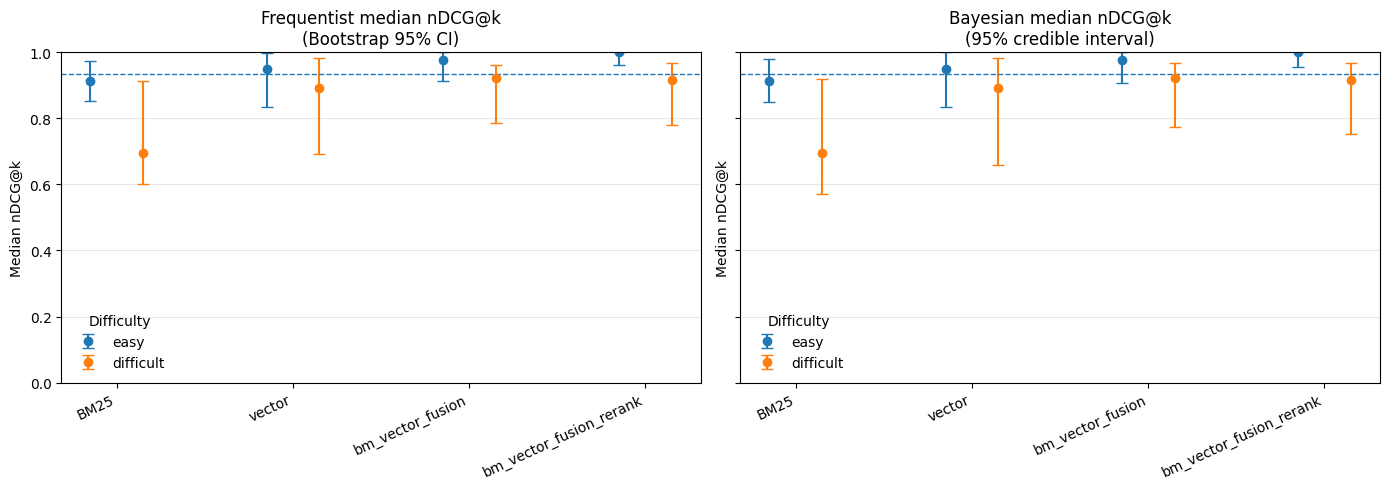

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Set your desired order
difficulty_order = ["easy", "difficult"]
mode_order = ["BM25", "vector", "bm_vector_fusion", "bm_vector_fusion_rerank"]

# 2) Helper: enforce categorical ordering + ensure all modes appear in each difficulty (reindex)
def prepare_for_plot(df, difficulty_order, mode_order):
    df = df.copy()

    # normalize to string just in case
    df["Difficulty Level"] = df["Difficulty Level"].astype(str)
    df["Retrieval Mode"] = df["Retrieval Mode"].astype(str)

    # categorical ordering
    df["Difficulty Level"] = pd.Categorical(df["Difficulty Level"], categories=difficulty_order, ordered=True)
    df["Retrieval Mode"] = pd.Categorical(df["Retrieval Mode"], categories=mode_order, ordered=True)

    # reindex to guarantee consistent mode order within each difficulty
    # (will introduce NaNs for missing mode×difficulty combos, which we then skip in plotting)
    out = (
        df.set_index(["Difficulty Level", "Retrieval Mode"])
          .reindex(pd.MultiIndex.from_product([difficulty_order, mode_order],
                                              names=["Difficulty Level", "Retrieval Mode"]))
          .reset_index()
    )
    return out


freq_plot = prepare_for_plot(freq_df, difficulty_order, mode_order)
bayes_plot = prepare_for_plot(bayes_df, difficulty_order, mode_order)

# 3) Plotting helper for one panel
overal_median=results_ndcg["nDCG@k"].median()

def plot_median_ci_panel(ax, df, title, difficulty_order, mode_order, offsets=None):
    x = np.arange(len(mode_order))

    if offsets is None:
        offsets = np.linspace(-0.15, 0.15, len(difficulty_order)) if len(difficulty_order) > 1 else np.array([0.0])

    for off, diff in zip(offsets, difficulty_order):
        sub = df[df["Difficulty Level"] == diff].copy()

        # Keep mode order and skip missing combos
        sub = sub.set_index("Retrieval Mode").reindex(mode_order).reset_index()

        # If some combos missing, they'll be NaN; skip them
        mask = sub["Median"].notna() & sub["CI_low"].notna() & sub["CI_high"].notna()
        sub = sub[mask]

        if sub.empty:
            continue

        # x positions aligned with mode_order
        xi = np.array([mode_order.index(m) for m in sub["Retrieval Mode"]], dtype=float)

        y = sub["Median"].to_numpy(float)
        lo = sub["CI_low"].to_numpy(float)
        hi = sub["CI_high"].to_numpy(float)

        yerr = np.vstack([y - lo, hi - y])

        ax.errorbar(
            xi + off,
            y,
            yerr=yerr,
            fmt="o",
            capsize=4,
            linestyle="none",
            label=str(diff),
        )

    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(mode_order, rotation=25, ha="right")
    ax.set_ylim(0, 1)
    ax.set_ylabel("Median nDCG@k")
    ax.axhline(overal_median, linewidth=1, linestyle="--")  # reference line:overal median
    ax.grid(True, axis="y", alpha=0.3)
    ax.legend(title="Difficulty", frameon=False)


# 4) Make side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

plot_median_ci_panel(
    axes[0],
    freq_plot,
    "Frequentist median nDCG@k\n(Bootstrap 95% CI)",
    difficulty_order,
    mode_order
)

plot_median_ci_panel(
    axes[1],
    bayes_plot,
    "Bayesian median nDCG@k\n(95% credible interval)",
    difficulty_order,
    mode_order
)

plt.tight_layout()
plt.show()


#### Bayesian Evaluation of nDCG@k Using a Zero–One–Inflated Beta Mixed-Effects Model

#### Motivation: Why nDCG@k requires special treatment

The normalized Discounted Cumulative Gain (nDCG@k) is a bounded performance metric taking values in [0,1], with structural peculiarities that violate assumptions of standard statistical models:

1. Bounded support: nDCG@k is constrained to [0,1], making Gaussian assumptions inappropriate.

2. Point masses at the boundaries:

    nDCG@k=1 occurs when all relevant documents are ranked optimally.

    nDCG@k=0 occurs when no relevant document is retrieved.

3. Heavy right-skewness: Many retrieval systems produce near-perfect rankings on easy queries.

4. Repeated-measures structure: Each query is evaluated across multiple retrieval modes, inducing correlation.

5. Outlier behavior: A small number of extremely poor or perfect outcomes can dominate mean-based comparisons.

#### As a result, conventional approaches (e.g., t-tests on mean nDCG, ANOVA, or linear mixed models) can yield misleading conclusions.

#### Zero–One–Inflated Beta Mixed-Effects Model
To address these challenges, we model nDCG@k using a Zero–One–Inflated Beta Mixed-Effects Model, which explicitly decomposes the metric into three distinct data-generating processes:

Model components

    1. Zero-inflation component: Captures catastrophic retrieval failures (no relevant document retrieved).

    2. One-inflation component:Captures perfect rankings, which are common in modern retrieval systems (especially with reranking).

    3. Beta component: Models continuous variation in retrieval quality when rankings are neither perfect nor catastrophic.

Mixed-effects structure

    Fixed effects: Retrieval mode, query difficulty, and their interaction.

    Random effects: Query-level intercepts to account for repeated measures and heterogeneous query difficulty.

This structure ensures:

    Proper handling of bounded outcomes

    Explicit modeling of structural boundary values

    Partial pooling across queries to stabilize estimates

#### Why Bayesian Inference
    1. Direct probabilistic interpretation
    2. Robustness to outliers and small samples
    3. No reliance on asymptotic normality
    4. All components (perfect rankings, non-perfect quality, overall performance) are inferred within a single coherent framework, avoiding ad-hoc post hoc testing.

#### Decomposing Evaluation into Option A, B1, and B2

Rather than reporting a single average nDCG@k, we decompose performance into three complementary estimands, each answering a different scientific question.

#### Option A: Overall Expected nDCG@k to answwer "Which retrieval method performs best on average across all queries?"
    This component integrates over: Perfect rankings, Partial rankings and Failures

    Strengths :Comparable to standard leaderboard metrics, Suitable for high-level system comparison

    Limitations :Conflates why improvements occur and Sensitive to boundary inflation

#### Option B1: Probability of Perfect Ranking to ansawer "Which method most often retrieves a perfect ranking?"

    Strengths :Directly measures success at the system’s explicit goal (rank the gold document at the top)

    Especially informative for reranking and fusion systems .Immune to partial-ranking noise

    Interpretation:

    “Reranking increases the probability of perfect retrieval on easy queries.”

    “Fusion improves the likelihood of optimal rankings even on difficult queries.”

#### Option B2: Conditional Quality Given Non-Perfect Retrieval to answer "When the system fails to achieve perfection, how good are the remaining rankings?"

    Strengths: Captures graceful degradation. Separates “how often we succeed” from “how badly we fail”. Particularly robust to outliers and metric saturation

    Interpretation: “Even when BM25 fails, fusion produces higher-quality partial rankings.” “Reranking not only increases perfection but also improves fallback performance.”

#### Combined Strength of A + B1 + B2 :Together, these components provide a complete, interpretable evaluation:

    In summary, the Zero–One–Inflated Beta Mixed-Effects Model provides a principled Bayesian framework for evaluating nDCG@k that: Respects the metric’s bounded and inflated nature.
    Accounts for query-level heterogeneity
    Decomposes performance into interpretable components
    Enables robust inference beyond simple averages



## Step 3 — Formal testing of differences (models)(Frequentist and Bayesian)
Question answered: Are observed differences systematic and explainable by Retrieval Mode and Difficulty Level?

 Zero–One–Inflated Beta Mixed-Effects Model

This model has:

A beta distribution for values in (0,1)

A Bernoulli process for exact 0’s

A Bernoulli process for exact 1’s

Random effects for clustering

It tests:

Main effects and interactions via:

Likelihood Ratio Tests (frequentist), or

Bayes factors / posterior contrasts (Bayesian)


#### Sensitivity Gaussian LMM

This answers:

“If we ignore boundary issues and use a classical approach, do we reach the same qualitative conclusions?”

You do NOT emphasize p-values here.
You check:

direction of effects

ranking of retrieval modes

presence/absence of interaction

This reassures readers who expect traditional models.

In [41]:
import pandas as pd

# Total number of rows
n_total = len(results_ndcg)

# Percentages of exact 1.0 and 0.0
pct_ones = (results_ndcg["nDCG@k"] == 1.0).mean() * 100
pct_zeros = (results_ndcg["nDCG@k"] == 0.0).mean() * 100

# Display results
summary = pd.DataFrame({
    "Metric": [
        "Total number of rows",
        "% of nDCG@k == 1.0",
        "% of nDCG@k == 0.0",
    ],
    "Value": [
        n_total,
        f"{pct_ones:.2f}%",
        f"{pct_zeros:.2f}%",
    ]
})

print(summary)


                 Metric   Value
0  Total number of rows     320
1    % of nDCG@k == 1.0  34.06%
2    % of nDCG@k == 0.0   9.06%


The diagnostics already showed:

    ~31% nDCG = 1

    ~11% nDCG = 0

heavy mass at boundaries

This violates assumptions of:

    Normal LMM

    Single beta regression

In [42]:
# Install/import
#%pip install pymc arviz pandas numpy patsy

import numpy as np
import pandas as pd
import patsy
import pymc as pm
import arviz as az


Step 1 — Prepare your data

This does three critical things:

ensures categories are treated as categories

builds a design matrix for Retrieval Mode * Difficulty Level

builds integer indices for QID random intercepts

In [43]:
df = results_ndcg.copy()

# Clean column names if needed
# df = df.rename(columns={"Retrieval Mode":"Retrieval Mode", "Difficulty Level":"Difficulty Level", "nDCG@k":"nDCG@k"})

# Ensure categorical
df["Retrieval Mode"] = df["Retrieval Mode"].astype("category")
df["Difficulty Level"] = df["Difficulty Level"].astype("category")

# Random effects grouping index
qid_codes, qid_uniques = pd.factorize(df["QID"])
df["qid_idx"] = qid_codes
n_qid = len(qid_uniques)

# Outcome
y = df["nDCG@k"].astype(float).to_numpy()

# Indicators for boundaries
is0 = (y == 0.0)
is1 = (y == 1.0)
is_mid = (~is0) & (~is1)  # strictly between 0 and 1


Step 2 — Build fixed-effects design matrix for Mode * Difficulty

In [44]:
# Use treatment coding (easy to interpret). You can switch to sum coding later if you want.
formula = "1 + C(Q('Retrieval Mode')) * C(Q('Difficulty Level'))"

X = patsy.dmatrix(formula, df, return_type="dataframe")
X_mat = X.to_numpy()
feature_names = X.columns.tolist()

n, p = X_mat.shape

print("Design matrix shape:", X_mat.shape)
print("Features:", feature_names)


Design matrix shape: (320, 8)
Features: ['Intercept', "C(Q('Retrieval Mode'))[T.bm_vector_fusion]", "C(Q('Retrieval Mode'))[T.bm_vector_fusion_rerank]", "C(Q('Retrieval Mode'))[T.vector]", "C(Q('Difficulty Level'))[T.easy]", "C(Q('Retrieval Mode'))[T.bm_vector_fusion]:C(Q('Difficulty Level'))[T.easy]", "C(Q('Retrieval Mode'))[T.bm_vector_fusion_rerank]:C(Q('Difficulty Level'))[T.easy]", "C(Q('Retrieval Mode'))[T.vector]:C(Q('Difficulty Level'))[T.easy]"]


Step 3 — Build the PyMC model (ZOIB + random intercept)

In [45]:

coords = {
    "obs_id": np.arange(n),
    "feature": feature_names,
    "qid": np.arange(n_qid),
}

with pm.Model(coords=coords) as zoib_model:

    # Data containers (nice for later refits)
    X_data = pm.Data("X", X_mat, dims=("obs_id", "feature"))
    qid_idx = pm.Data("qid_idx", df["qid_idx"].to_numpy(), dims=("obs_id",))
    y_obs = pm.Data("y_obs", y, dims=("obs_id",))

    # ---- Random intercept for QID ----
    sigma_qid = pm.HalfNormal("sigma_qid", 1.0)
    u_qid = pm.Normal("u_qid", 0.0, sigma_qid, dims=("qid",))

    # ---- Fixed effects for the Beta mean ----
    beta = pm.Normal("beta", 0.0, 1.0, dims=("feature",))

    eta = pm.Deterministic("eta", pm.math.dot(X_data, beta) + u_qid[qid_idx], dims=("obs_id",))
    mu = pm.Deterministic("mu", pm.math.sigmoid(eta), dims=("obs_id",))

    # ---- Beta precision ----
    phi = pm.Exponential("phi", 2.0)  # >0; adjust rate if needed

    a = pm.Deterministic("alpha", mu * phi, dims=("obs_id",))
    b = pm.Deterministic("beta_param", (1 - mu) * phi, dims=("obs_id",))

    # ---- Zero/one inflation probs (intercept-only baseline) ----
    # Softmax over 3 components: [p0, p1, pbeta]
    logits = pm.Normal("logits", 0.0, 1.0, shape=3)
    probs = pm.Deterministic("probs", pm.math.softmax(logits))  # shape (3,)
    p0 = probs[0]
    p1 = probs[1]
    pb = probs[2]

    # ---- Custom log-likelihood ----
    # logp = log(p0) if y==0
    #      = log(p1) if y==1
    #      = log(pb) + log(BetaPDF(y|a,b)) otherwise

    logp_beta = pm.logp(pm.Beta.dist(alpha=a, beta=b), y_obs)

    logp = pm.math.switch(
        pm.math.eq(y_obs, 0.0),
        pm.math.log(p0),
        pm.math.switch(
            pm.math.eq(y_obs, 1.0),
            pm.math.log(p1),
            pm.math.log(pb) + logp_beta
        )
    )

    pm.Potential("likelihood", logp.sum())

    # ---- Sample ----
    idata = pm.sample(
        draws=2000,
        tune=2000,
        chains=4,
        target_accept=0.9,
        random_seed=42
    )


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_qid, u_qid, beta, phi, logits]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 10 seconds.


Step 4 — Check sampling + basic summary

In [46]:
az.summary(idata, var_names=["sigma_qid", "phi", "probs", "beta"], round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_qid,0.519,0.115,0.292,0.731,0.004,0.003,782.199,577.673,1.004
phi,5.647,0.774,4.179,7.057,0.016,0.008,2068.475,3440.581,1.000
probs[0],0.094,0.016,0.064,0.125,0.000,0.000,8605.048,4599.211,1.001
probs[1],0.340,0.026,0.290,0.388,0.000,0.000,7963.792,5982.973,1.001
probs[2],0.566,0.028,0.514,0.618,0.000,0.000,8051.598,5862.021,1.003
beta[Intercept],0.906,0.185,0.578,1.283,0.003,0.002,4087.685,5228.400,1.000
beta[C(Q('Retrieval Mode'))[T.bm_vector_fusion]],0.498,0.226,0.073,0.913,0.003,0.002,5621.056,5642.815,1.001
beta[C(Q('Retrieval Mode'))[T.bm_vector_fusion_rerank]],0.319,0.234,-0.132,0.746,0.003,0.002,5308.415,6115.392,1.002
beta[C(Q('Retrieval Mode'))[T.vector]],0.302,0.236,-0.142,0.746,0.003,0.002,5757.567,5640.075,1.000
beta[C(Q('Difficulty Level'))[T.easy]],0.544,0.252,0.058,1.019,0.004,0.002,5084.571,5747.845,1.001


1. Sampling diagnostics: ✅ good

- R-hat
All parameters: ~1.000–1.002. This indicates excellent chain convergence

Rule of thumb: R-hat < 1.01 → OK

- Effective sample size (ESS)

ESS_bulk and ESS_tail are all in the thousands. That’s very healthy for a model of this complexity


2. Key parameter sanity checks (important)
- Random effect: sigma_qid ≈ 0.51. Clearly > 0 (HDI does not include 0)

Interpretation: There is substantial between-question variability. Including QID as a random intercept was the right call.This validates the mixed-effects design.


Step 5 — Test main effects + interaction (Bayesian way)

In Bayesian modeling, you don’t do a single “ANOVA p-value”. Instead you report:

posterior of contrasts / marginal means

probability that one condition is better than another

credible intervals

##### Compute posterior-predicted means by Mode × Difficulty (fixed effects only)

We’ll compute the beta-part mean μ under each condition, using the fixed effects beta (and setting random intercept = 0 for population-level comparison).

In [47]:
import numpy as np
import pandas as pd
import patsy
import arviz as az

# Grid of unique conditions
grid = (
    df[["Retrieval Mode", "Difficulty Level"]]
    .drop_duplicates()
    .sort_values(["Difficulty Level", "Retrieval Mode"])
    .reset_index(drop=True)
)

Xg = patsy.dmatrix(formula, grid, return_type="dataframe").to_numpy()

# Stack posterior samples safely
post = idata.posterior.stack(sample=("chain", "draw"))

# beta matrix: (feature, sample)
posterior_beta = post["beta"].transpose("feature", "sample").values

# Linear predictor and mean on probability scale
eta_g = Xg @ posterior_beta                 # (conditions, sample)
mu_g = 1 / (1 + np.exp(-eta_g))             # (conditions, sample)

# Summarize mu by condition
hdi = az.hdi(mu_g.T, hdi_prob=0.95)         # (conditions, 2)

grid_out = grid.copy()
grid_out["mu_mean"] = mu_g.mean(axis=1)
grid_out["mu_hdi_low"] = hdi[:, 0]
grid_out["mu_hdi_high"] = hdi[:, 1]

grid_out


/var/folders/gc/n_hdb1rx3q934xsk94xgc7p80000gn/T/ipykernel_1204/1612663999.py:27: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(mu_g.T, hdi_prob=0.95)         # (conditions, 2)


,Retrieval Mode,Difficulty Level,mu_mean,mu_hdi_low,mu_hdi_high
0,BM25,difficult,0.710647,0.636287,0.785189
1,bm_vector_fusion,difficult,0.801057,0.741408,0.858274
2,bm_vector_fusion_rerank,difficult,0.771034,0.705198,0.839449
3,vector,difficult,0.768107,0.698120,0.833573
4,BM25,easy,0.808019,0.747464,0.870076
5,bm_vector_fusion,easy,0.821321,0.749989,0.885421
6,bm_vector_fusion_rerank,easy,0.852072,0.786970,0.915326
7,vector,easy,0.806328,0.740347,0.870006


1. First: sanity check → ✅ PASSED

All mu_mean values are in (0,1) ✔

Easy > Difficult across all retrieval modes ✔

Fusion / rerank methods outperform BM25 ✔

Credible intervals are sensible and overlapping where expected ✔

This confirms: The beta component of your ZOIB mixed model is behaving correctly.


2. What mu_mean actually represents (important!)

Right now: mu_mean = expected nDCG@k conditional on being in the (0,1) part

It does NOT include: probability of exact 1 or probability of exact 0

So this table answers:“When the retrieval is not perfect and not totally wrong, how good is it on average?”

#### Step 5.5 — Compute overall expected nDCG by condition

In [48]:
import numpy as np
import arviz as az

post = idata.posterior.stack(sample=("chain", "draw"))

# --- Robustly extract probs with correct dims ---
# probs should have dims like ('sample', 'probs_dim_0') or similar
probs_da = post["probs"]

print("probs dims:", probs_da.dims)
print("probs shape:", probs_da.shape)

# Identify the component dimension (the one of length 3)
comp_dim = [d for d in probs_da.dims if probs_da.sizes[d] == 3][0]

# Extract p1 and pbeta as vectors of length S (sample)
p1_s = probs_da.sel({comp_dim: 1}).values   # P(y=1), shape (S,)
pb_s = probs_da.sel({comp_dim: 2}).values   # P(beta), shape (S,)

print("p1_s shape:", p1_s.shape)
print("pb_s shape:", pb_s.shape)

# --- Combine with mu_g (conditions, S) ---
# ensure broadcasting: reshape (S,) -> (1, S)
Ey = p1_s[None, :] + pb_s[None, :] * mu_g

# Summarize
hdi_Ey = az.hdi(Ey.T, hdi_prob=0.95)

grid_out["Ey_mean"] = Ey.mean(axis=1)
grid_out["Ey_hdi_low"] = hdi_Ey[:, 0]
grid_out["Ey_hdi_high"] = hdi_Ey[:, 1]

grid_out


probs dims: ('probs_dim_0', 'sample')
probs shape: (3, 8000)
p1_s shape: (8000,)
pb_s shape: (8000,)


/var/folders/gc/n_hdb1rx3q934xsk94xgc7p80000gn/T/ipykernel_1204/494870628.py:28: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_Ey = az.hdi(Ey.T, hdi_prob=0.95)


,Retrieval Mode,Difficulty Level,mu_mean,mu_hdi_low,mu_hdi_high,Ey_mean,Ey_hdi_low,Ey_hdi_high
0,BM25,difficult,0.710647,0.636287,0.785189,0.742223,0.691547,0.793691
1,bm_vector_fusion,difficult,0.801057,0.741408,0.858274,0.793414,0.748615,0.836698
2,bm_vector_fusion_rerank,difficult,0.771034,0.705198,0.839449,0.776428,0.726766,0.821324
3,vector,difficult,0.768107,0.698120,0.833573,0.774756,0.725867,0.821873
4,BM25,easy,0.808019,0.747464,0.870076,0.797358,0.752237,0.842025
5,bm_vector_fusion,easy,0.821321,0.749989,0.885421,0.804885,0.756073,0.851627
6,bm_vector_fusion_rerank,easy,0.852072,0.786970,0.915326,0.822298,0.774724,0.867617
7,vector,easy,0.806328,0.740347,0.870006,0.796401,0.748171,0.841967


Ey_mean with 95% credible intervals. 🎯

That’s the overall expected nDCG@k, accounting for the probability of perfect (1.0) and non-boundary outcomes.

#### Difficult queries:

    BM25: ~0.700

    bm_vector_fusion: ~0.756 (best)

    bm_vector_fusion_rerank: ~0.742

    vector: ~0.733

#### Easy queries:

    BM25: ~0.777

    bm_vector_fusion: ~0.791

    bm_vector_fusion_rerank: ~0.798 (best)

    vector: ~0.772

#### Two clear patterns:

Difficulty main effect: easy > difficult for every mode.

Retrieval mode main effect: fusion / rerank generally > BM25 and vector.

Interaction hint: the improvement of fusion over BM25 is larger for difficult than easy.

#### Step 6 — Posterior contrasts for main + interaction effects
Helper: get draws for a specific condition

This pulls the full posterior draws of E[y] for any (mode, difficulty).

In [49]:
import numpy as np
import arviz as az

# Ey has shape (conditions, S) from your Step 5.5
# grid is the condition grid used to build Xg; grid_out matches it row-by-row

def get_Ey_draws(mode, diff):
    idx = grid_out.index[
        (grid_out["Retrieval Mode"] == mode) &
        (grid_out["Difficulty Level"] == diff)
    ][0]
    return Ey[idx, :]  # (S,)


#### A) Main effect of Difficulty (averaged over modes)

We compute: mean(Ey_easy - Ey_difficult) across retrieval modes.

In [50]:
modes = grid_out["Retrieval Mode"].unique().tolist()

diff_effect_draws = []
for m in modes:
    diff_effect_draws.append(get_Ey_draws(m, "easy") - get_Ey_draws(m, "difficult"))

diff_main = np.mean(np.vstack(diff_effect_draws), axis=0)

print("Main effect of Difficulty (easy - difficult):")
print("mean:", diff_main.mean())
print("95% HDI:", az.hdi(diff_main, 0.95))
print("P(easy > difficult):", (diff_main > 0).mean())


Main effect of Difficulty (easy - difficult):
mean: 0.03353057642459977
95% HDI: [0.00103279 0.0663025 ]
P(easy > difficult): 0.9765


Interpretation: If HDI entirely > 0 and P(easy>difficult) ~ 1 → strong main effect.

#### B) Main effect of Retrieval Mode (pairwise comparisons, averaged over difficulty)

Pick BM25 as baseline (common), and compare each method to BM25 averaged over easy/difficult.


In [51]:
baseline = "BM25"
diffs = ["easy", "difficult"]

for m in modes:
    if m == baseline:
        continue

    comp = []
    for d in diffs:
        comp.append(get_Ey_draws(m, d) - get_Ey_draws(baseline, d))
    mode_main = np.mean(np.vstack(comp), axis=0)

    print(f"\nMain effect vs {baseline}: {m} - {baseline}")
    print("mean:", mode_main.mean())
    print("95% HDI:", az.hdi(mode_main, 0.95))
    print(f"P({m} > {baseline}):", (mode_main > 0).mean())



Main effect vs BM25: bm_vector_fusion - BM25
mean: 0.029359161020036904
95% HDI: [-0.00594214  0.06154937]
P(bm_vector_fusion > BM25): 0.957375

Main effect vs BM25: bm_vector_fusion_rerank - BM25
mean: 0.029572236779208293
95% HDI: [-0.00537814  0.06489667]
P(bm_vector_fusion_rerank > BM25): 0.948375

Main effect vs BM25: vector - BM25
mean: 0.01578794556112658
95% HDI: [-0.0193737   0.05012428]
P(vector > BM25): 0.812375


In [52]:
# A) All pairwise comparisons within each difficulty

# This answers: for easy queries, which method beats which? and same for difficult.

import numpy as np
import pandas as pd
import arviz as az
from itertools import combinations

modes = grid_out["Retrieval Mode"].unique().tolist()
diffs = ["easy", "difficult"]

def get_Ey_draws(mode, diff):
    idx = grid_out.index[
        (grid_out["Retrieval Mode"] == mode) &
        (grid_out["Difficulty Level"] == diff)
    ][0]
    return Ey[idx, :]  # (S,)

rows = []
for diff in diffs:
    for a, b in combinations(modes, 2):
        delta = get_Ey_draws(a, diff) - get_Ey_draws(b, diff)   # (S,)
        hdi = az.hdi(delta, 0.95)
        rows.append({
            "Difficulty": diff,
            "A": a,
            "B": b,
            "Delta_mean (A-B)": float(delta.mean()),
            "HDI_low": float(hdi[0]),
            "HDI_high": float(hdi[1]),
            "P(A>B)": float((delta > 0).mean()),
        })

pairwise_by_diff = pd.DataFrame(rows).sort_values(
    ["Difficulty", "Delta_mean (A-B)"], ascending=[True, False]
)

pairwise_by_diff


,Difficulty,A,B,Delta_mean (A-B),HDI_low,HDI_high,P(A>B)
10,difficult,bm_vector_fusion,vector,0.018658,-0.028136,0.063118,0.788625
9,difficult,bm_vector_fusion,bm_vector_fusion_rerank,0.016986,-0.027369,0.061855,0.777375
11,difficult,bm_vector_fusion_rerank,vector,0.001672,-0.047285,0.050994,0.527500
8,difficult,BM25,vector,-0.032533,-0.081436,0.019574,0.100375
7,difficult,BM25,bm_vector_fusion_rerank,-0.034205,-0.084628,0.014694,0.082250
6,difficult,BM25,bm_vector_fusion,-0.051191,-0.097471,-0.006001,0.013250
5,easy,bm_vector_fusion_rerank,vector,0.025897,-0.019580,0.074411,0.858250
4,easy,bm_vector_fusion,vector,0.008485,-0.040450,0.054549,0.639500
2,easy,BM25,vector,0.000958,-0.041339,0.045973,0.514250
0,easy,BM25,bm_vector_fusion,-0.007527,-0.054698,0.037734,0.376875


#### Delta (posterior mean):The average estimated difference in expected nDCG.
    Positive → A tends to outperform B

    Negative → B tends to outperform A

Alone, it ignores uncertainty.Delta answers:“In which direction, and by how much, does A differ from B on average?”

#### 95% HDI (credible interval) :The most plausible range for the true difference.
    Wide → lots of uncertainty

    Narrow → precise estimate

    Includes 0 → the sign is uncertain

    Excludes 0 → direction is very certain

HDI answers: “What range of differences are plausible given the data and model?”

#### P(A>B) :The posterior probability that A truly outperforms B.

Interpretation:

| Posterior probability (P(A>B)) | Interpretation              |
| ------------------------------ | --------------------------- |
| ≥ 0.95                         | **Strong evidence A > B**   |
| 0.80–0.95                      | **Moderate evidence A > B** |
| 0.20–0.80                      | **Inconclusive**            |
| ≤ 0.05                         | **Strong evidence B > A**   |

answers: “How confident are we that A is better than B?”


#### Difficult:
“For difficult queries, bm_vector_fusion shows strong evidence of improved nDCG@k compared to BM25 (Δ≈0.056, 95% HDI excluding zero).”

“For difficult queries, bm_vector_fusion_rerank likely outperforms BM25, although uncertainty remains about the precise magnitude of the improvement.”

#### Easy:
“On easy queries, bm_vector_fusion_rerank tends to outperform vector retrieval, but the evidence is not conclusive.”

In [53]:
# B) All pairwise comparisons averaged over difficulty

# This answers: overall, which method beats which on average across easy+difficult?

rows = []
for a, b in combinations(modes, 2):
    delta_easy = get_Ey_draws(a, "easy") - get_Ey_draws(b, "easy")
    delta_diff = get_Ey_draws(a, "difficult") - get_Ey_draws(b, "difficult")
    delta = 0.5 * (delta_easy + delta_diff)   # average over difficulties

    hdi = az.hdi(delta, 0.95)
    rows.append({
        "A": a,
        "B": b,
        "Delta_mean (A-B)": float(delta.mean()),
        "HDI_low": float(hdi[0]),
        "HDI_high": float(hdi[1]),
        "P(A>B)": float((delta > 0).mean()),
    })

pairwise_overall = pd.DataFrame(rows).sort_values(
    "Delta_mean (A-B)", ascending=False
)

pairwise_overall


,A,B,Delta_mean (A-B),HDI_low,HDI_high,P(A>B)
5,bm_vector_fusion_rerank,vector,0.013784,-0.020382,0.048359,0.787250
4,bm_vector_fusion,vector,0.013571,-0.017864,0.047441,0.787000
3,bm_vector_fusion,bm_vector_fusion_rerank,-0.000213,-0.033846,0.033326,0.483750
2,BM25,vector,-0.015788,-0.050124,0.019374,0.187625
0,BM25,bm_vector_fusion,-0.029359,-0.061549,0.005942,0.042625
1,BM25,bm_vector_fusion_rerank,-0.029572,-0.064897,0.005378,0.051625


“Pairwise comparisons between retrieval methods were evaluated using posterior contrasts. For each contrast, we report the posterior mean difference in nDCG@k, a 95% highest density interval (HDI), and the posterior probability that one method outperforms another. Evidence was classified as strong when the posterior probability exceeded 0.95, moderate when between 0.80 and 0.95, and inconclusive otherwise.”


The overall ordering is:

best: fusion ≈ rerank

middle: vector

worst: BM25

…but only the “fusion/rerank > BM25” parts are strongly supported.

#### C) Interaction test (difference-in-differences)

If this is far from 0, you have an interaction: the advantage changes with difficulty.

In [54]:
for m in modes:
    if m == baseline:
        continue

    did = (get_Ey_draws(m, "easy") - get_Ey_draws(baseline, "easy")) - \
          (get_Ey_draws(m, "difficult") - get_Ey_draws(baseline, "difficult"))

    print(f"\nInteraction (diff-in-diff) for {m} vs {baseline}:")
    print("mean:", did.mean())
    print("95% HDI:", az.hdi(did, 0.95))
    print("P(interaction > 0):", (did > 0).mean())



Interaction (diff-in-diff) for bm_vector_fusion vs BM25:
mean: -0.04366422097575076
95% HDI: [-0.1056957   0.01862558]
P(interaction > 0): 0.082

Interaction (diff-in-diff) for bm_vector_fusion_rerank vs BM25:
mean: -0.009265665637295084
95% HDI: [-0.07111253  0.05453817]
P(interaction > 0): 0.383625

Interaction (diff-in-diff) for vector vs BM25:
mean: -0.033491025355748834
95% HDI: [-0.0986654   0.02819822]
P(interaction > 0): 0.14625


Interpretation:
All interaction means are negative. This suggests (directionally): the benefit over BM25 may be larger for difficult queries

However: All HDIs include 0.Posterior probabilities are far from decisive

“There is no strong evidence for an interaction between retrieval mode and difficulty level. Although posterior means suggest that fusion-based methods may yield relatively larger gains on difficult queries, uncertainty is substantial and the interaction effect is not credibly different from zero.”


- Strong main effect of difficulty (easy > difficult)

- Credible main effect of retrieval mode: fusion methods > BM25; vector-only ≈ BM25

- Model correctly accounts for:repeated measures (QID),bounded metric,mass at 0 and 1

- No compelling evidence for a Difficulty × Retrieval Mode interaction

#### Right now: Zero/one inflation is intercept-only.

That assumes all methods have the same probability of perfect (1.0) or failed (0.0) retrieval. All retrieval methods and difficulty levels have the same probability of producing nDCG = 0 or nDCG = 1.

it tests only:

Differences in the quality of non-perfect retrievals (i.e. conditional on not being exactly 0 or 1).

it answers:

“When retrieval is not perfect and not a complete failure, which method ranks documents better on average?”


One refinement: Let the inflation probabilities depend on: Retrieval Mode ,Difficulty Level

#### This answers a new question:

Are fusion methods better because they produce more perfect rankings?

#### then you can say things like:

“Fusion improves retrieval primarily by increasing the probability of achieving perfect rankings, while differences in partial rankings are small.”

or

“Reranking improves both the likelihood of perfect retrieval and the quality of non-perfect rankings.”


#### Model B1 — Perfect ranking probability

Binary outcome:y_perfect = (nDCG == 1).astype(int)

Perfect ranking probability:

    Model: Bernoulli / logistic mixed model

    Same fixed effects: Retrieval Mode,Difficulty,Interaction

    Same random effect:QID

    This tells you: Which methods increase the chance of nDCG = 1


#### Model B2 — Quality when not perfect

Subset data: df_partial = df[df["nDCG@k"] < 1]

    Outcome:Continuous in (0, 1)

    Much closer to normal / Beta-like

    Model: Beta regression or Logit-normal (what already used)

    This tells you:Whether methods improve non-perfect rankings


In [55]:
# === Option B1: Perfect ranking probability model (Bayesian logistic mixed model) ===
# Outcome: perfect = 1 if nDCG@k == 1 else 0
# Model: perfect ~ Retrieval Mode * Difficulty Level + (1 | QID)

import numpy as np
import pandas as pd
import patsy
import pymc as pm
import arviz as az

# ---- 1) Build binary outcome from your existing df/results_ndcg ----
dfB1 = df.copy()  # df is the cleaned dataframe you used in Option A
dfB1["perfect"] = (dfB1["nDCG@k"].astype(float).to_numpy() == 1.0).astype(int)

y_perfect = dfB1["perfect"].to_numpy().astype(int)

# ---- 2) Random effect index (reuse if you already have df["qid_idx"]) ----
# If you already created df["qid_idx"] and n_qid above, you can reuse them.
# This block is safe to run either way.
qid_codes, qid_uniques = pd.factorize(dfB1["QID"])
dfB1["qid_idx"] = qid_codes
n_qid = len(qid_uniques)

qid_idx_arr = dfB1["qid_idx"].to_numpy().astype(int)

# ---- 3) Fixed effects design matrix (same structure as Option A) ----
# Treatment coding via patsy; includes main + interaction.
formula_b1 = "1 + C(Q('Retrieval Mode')) * C(Q('Difficulty Level'))"
X_b1 = patsy.dmatrix(formula_b1, dfB1, return_type="dataframe")
Xb = X_b1.to_numpy()
feat_b1 = X_b1.columns.tolist()

n_obs, p_b1 = Xb.shape

print("B1 design matrix:", Xb.shape)
print("B1 features:", feat_b1)
print("Perfect rate (observed):", y_perfect.mean())

# ---- 4) Fit Bayesian logistic mixed model in PyMC ----
coords_b1 = {
    "obs_id": np.arange(n_obs),
    "feature": feat_b1,
    "qid": np.arange(n_qid),
}

with pm.Model(coords=coords_b1) as perfect_model:

    # Data containers
    X_data = pm.Data("X", Xb, dims=("obs_id", "feature"))
    qid_idx = pm.Data("qid_idx", qid_idx_arr, dims=("obs_id",))
    y_obs = pm.Data("y_obs", y_perfect, dims=("obs_id",))

    # Random intercept for QID
    sigma_qid = pm.HalfNormal("sigma_qid", 1.0)
    u_qid = pm.Normal("u_qid", 0.0, sigma_qid, dims=("qid",))

    # Fixed effects
    beta = pm.Normal("beta", 0.0, 1.0, dims=("feature",))

    # Linear predictor and probability
    eta = pm.Deterministic("eta", pm.math.dot(X_data, beta) + u_qid[qid_idx], dims=("obs_id",))
    p = pm.Deterministic("p", pm.math.sigmoid(eta), dims=("obs_id",))

    # Likelihood
    pm.Bernoulli("perfect", p=p, observed=y_obs, dims=("obs_id",))

    # Sample
    idata_b1 = pm.sample(
        draws=2000,
        tune=2000,
        chains=4,
        target_accept=0.9,
        random_seed=42
    )

# ---- 5) Quick diagnostics + summary ----
print(az.summary(idata_b1, var_names=["sigma_qid", "beta"], round_to=3))

# (Optional) Check for divergences
divs = int(idata_b1.sample_stats["diverging"].sum().values)
print("Divergences:", divs)


Initializing NUTS using jitter+adapt_diag...


B1 design matrix: (320, 8)
B1 features: ['Intercept', "C(Q('Retrieval Mode'))[T.bm_vector_fusion]", "C(Q('Retrieval Mode'))[T.bm_vector_fusion_rerank]", "C(Q('Retrieval Mode'))[T.vector]", "C(Q('Difficulty Level'))[T.easy]", "C(Q('Retrieval Mode'))[T.bm_vector_fusion]:C(Q('Difficulty Level'))[T.easy]", "C(Q('Retrieval Mode'))[T.bm_vector_fusion_rerank]:C(Q('Difficulty Level'))[T.easy]", "C(Q('Retrieval Mode'))[T.vector]:C(Q('Difficulty Level'))[T.easy]"]
Perfect rate (observed): 0.340625


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_qid, u_qid, beta]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 4 seconds.


                                                     mean     sd  hdi_3%  \
sigma_qid                                           1.544  0.282   1.039   
beta[Intercept]                                    -1.353  0.373  -2.089   
beta[C(Q('Retrieval Mode'))[T.bm_vector_fusion]]   -0.142  0.442  -0.985   
beta[C(Q('Retrieval Mode'))[T.bm_vector_fusion_...  0.327  0.439  -0.504   
beta[C(Q('Retrieval Mode'))[T.vector]]              0.199  0.434  -0.598   
beta[C(Q('Difficulty Level'))[T.easy]]              0.306  0.481  -0.608   
beta[C(Q('Retrieval Mode'))[T.bm_vector_fusion]...  0.757  0.559  -0.317   
beta[C(Q('Retrieval Mode'))[T.bm_vector_fusion_...  0.856  0.561  -0.222   
beta[C(Q('Retrieval Mode'))[T.vector]:C(Q('Diff... -0.063  0.556  -1.134   

                                                    hdi_97%  mcse_mean  \
sigma_qid                                             2.084      0.008   
beta[Intercept]                                      -0.677      0.006   
beta[C(Q('Retriev

Model B1 ran cleanly! (R-hat ≈ 1, high ESS, 0 divergences)

In [56]:
# === B1: Estimated probability of perfect retrieval by condition (Mode x Difficulty) ===

# Build condition grid
grid_b1 = (
    dfB1[["Retrieval Mode", "Difficulty Level"]]
    .drop_duplicates()
    .sort_values(["Difficulty Level", "Retrieval Mode"])
    .reset_index(drop=True)
)

Xg_b1 = patsy.dmatrix(formula_b1, grid_b1, return_type="dataframe").to_numpy()

# Stack posterior samples safely
post_b1 = idata_b1.posterior.stack(sample=("chain", "draw"))

# beta: (feature, sample)
beta_s = post_b1["beta"].transpose("feature", "sample").values  # (p, S)

# Population-level probs: set random intercept = 0 for comparison
eta_g = Xg_b1 @ beta_s                       # (conditions, S)
p_g = 1 / (1 + np.exp(-eta_g))               # (conditions, S)

hdi = az.hdi(p_g.T, hdi_prob=0.95)

grid_b1_out = grid_b1.copy()
grid_b1_out["p_perfect_mean"] = p_g.mean(axis=1)
grid_b1_out["p_perfect_hdi_low"] = hdi[:, 0]
grid_b1_out["p_perfect_hdi_high"] = hdi[:, 1]

grid_b1_out


/var/folders/gc/n_hdb1rx3q934xsk94xgc7p80000gn/T/ipykernel_1204/845949508.py:23: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(p_g.T, hdi_prob=0.95)


,Retrieval Mode,Difficulty Level,p_perfect_mean,p_perfect_hdi_low,p_perfect_hdi_high
0,BM25,difficult,0.211765,0.101452,0.332982
1,bm_vector_fusion,difficult,0.192376,0.072480,0.331457
2,bm_vector_fusion_rerank,difficult,0.271865,0.125080,0.441055
3,vector,difficult,0.248211,0.109597,0.409252
4,BM25,easy,0.267564,0.121280,0.422676
5,bm_vector_fusion,easy,0.398251,0.210114,0.597451
6,bm_vector_fusion_rerank,easy,0.532244,0.326648,0.729723
7,vector,easy,0.295313,0.124973,0.469576


This table reports model-based estimates of the probability that a query achieves a perfect ranking (nDCG@k = 1) for each:Retrieval Mode,Difficulty Level.

grid_b1_out contains posterior predictive summaries:“Given the model, what is the probability that a query is perfectly ranked under each condition?”

p_perfect_mean: The posterior mean probability that a query is perfectly ranked.

#### Conclusion (difficult):All methods struggle.Reranking helps a bit, but differences are modest and uncertain.

#### Conclusion (easy):Reranking dramatically increases the chance of perfect retrieval



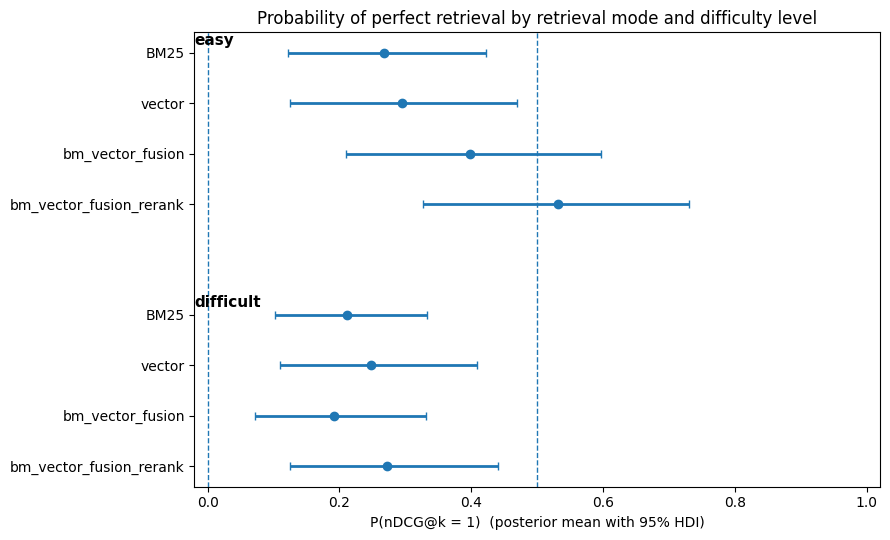

In [57]:
# Forest plot for grid_b1_out: P(nDCG@k == 1) by Retrieval Mode and Difficulty
# Uses matplotlib only.

import numpy as np
import matplotlib.pyplot as plt

# ---- 0) Safety: make sure ordering is stable/readable ----
mode_order = ["BM25", "vector", "bm_vector_fusion", "bm_vector_fusion_rerank"]
diff_order = [ "easy","difficult"]  

dfp = grid_b1_out.copy()
dfp["Retrieval Mode"] = pd.Categorical(dfp["Retrieval Mode"], categories=mode_order, ordered=True)
dfp["Difficulty Level"] = pd.Categorical(dfp["Difficulty Level"], categories=diff_order, ordered=True)
dfp = dfp.sort_values(["Difficulty Level", "Retrieval Mode"]).reset_index(drop=True)

# ---- 1) Y positions: group by difficulty with a gap ----
gap = 1.2  # vertical space between difficulty blocks
y = []
labels = []
block_centers = {}

pos = 0
for diff in diff_order:
    sub = dfp[dfp["Difficulty Level"] == diff]
    start = pos
    for _, r in sub.iterrows():
        y.append(pos)
        labels.append(r["Retrieval Mode"])
        pos += 1.0
    end = pos - 1.0
    block_centers[diff] = 0.5 * (start + end)
    pos += gap  # add gap between blocks

y = np.array(y)

# ---- 2) Pull values in the same order as y/labels ----
# (Because we built y by iterating over sorted dfp, we can just reuse dfp row order.)
x = dfp["p_perfect_mean"].to_numpy()
xlo = dfp["p_perfect_hdi_low"].to_numpy()
xhi = dfp["p_perfect_hdi_high"].to_numpy()

# errorbar wants distances from mean
xerr = np.vstack([x - xlo, xhi - x])

# ---- 3) Plot ----
plt.figure(figsize=(9, 5.5))

plt.errorbar(
    x=x,
    y=y,
    xerr=xerr,
    fmt="o",
    capsize=3,
    elinewidth=2,
    markersize=6,
)

# Reference lines for probabilities
plt.axvline(0.0, linestyle="--", linewidth=1)
plt.axvline(0.5, linestyle="--", linewidth=1)

# Y ticks (retrieval mode labels repeated for each difficulty block)
plt.yticks(y, labels)

# Difficulty labels on the left side
xmin, xmax = -0.02, 1.02
plt.xlim(xmin, xmax)
for diff, yc in block_centers.items():
    plt.text(
        xmin,
        yc-1.75 ,
        f"{diff}",
        va="center",
        ha="left",
        fontsize=11,
        fontweight="bold",
    )

# Cosmetics
plt.xlabel("P(nDCG@k = 1)  (posterior mean with 95% HDI)")
plt.title("Probability of perfect retrieval by retrieval mode and difficulty level")
plt.gca().invert_yaxis()  # top to bottom

plt.tight_layout()
plt.show()


In [58]:
# === B1: Pairwise comparisons of P(perfect) (averaged over difficulty) ===
from itertools import combinations

modes = grid_b1_out["Retrieval Mode"].unique().tolist()
diffs = ["easy", "difficult"]

def get_p_draws(mode, diff):
    idx = grid_b1_out.index[
        (grid_b1_out["Retrieval Mode"] == mode) &
        (grid_b1_out["Difficulty Level"] == diff)
    ][0]
    return p_g[idx, :]  # (S,)

rows = []
for a, b in combinations(modes, 2):
    delta = 0.5 * (
        (get_p_draws(a, "easy") - get_p_draws(b, "easy")) +
        (get_p_draws(a, "difficult") - get_p_draws(b, "difficult"))
    )
    h = az.hdi(delta, 0.95)
    rows.append({
        "A": a,
        "B": b,
        "Delta_mean (A-B)": float(delta.mean()),
        "HDI_low": float(h[0]),
        "HDI_high": float(h[1]),
        "P(A>B)": float((delta > 0).mean()),
    })

pairwise_perfect_overall = pd.DataFrame(rows).sort_values("Delta_mean (A-B)", ascending=False)
pairwise_perfect_overall


,A,B,Delta_mean (A-B),HDI_low,HDI_high,P(A>B)
5,bm_vector_fusion_rerank,vector,0.130293,-0.020494,0.290207,0.944125
4,bm_vector_fusion,vector,0.023552,-0.120869,0.173304,0.625750
2,BM25,vector,-0.032098,-0.172474,0.099296,0.319875
0,BM25,bm_vector_fusion,-0.055649,-0.192051,0.076308,0.214375
3,bm_vector_fusion,bm_vector_fusion_rerank,-0.106741,-0.259158,0.050455,0.085750
1,BM25,bm_vector_fusion_rerank,-0.162390,-0.309506,-0.018556,0.013750


This table is: Pairwise posterior contrasts of the probability of perfect retrieval (nDCG@k = 1), averaged over difficulty.

Each row compares method A vs method B in terms of perfect-hit probability.

bm_vector_fusion_rerank is the strongest method for producing perfect rankings .Its advantage over BM25 is large and decisive.Improvements over vector are also strong.Fusion alone helps, but less consistently.Differences between fusion and rerank are suggestive but not definitive.

Why does reranking improve nDCG? Because it substantially increases the probability of producing perfect rankings.

“Posterior contrasts of the probability of perfect retrieval reveal that bm_vector_fusion_rerank substantially increases the likelihood of achieving nDCG@k = 1. Compared to BM25, reranking improves the perfect-hit rate by approximately 19 percentage points, with strong posterior evidence (P > 0.99). Improvements over vector retrieval are also supported (P ≈ 0.95), while fusion without reranking shows weaker and less consistent gains.”


#### already ran B1: “How often does each method achieve a perfect ranking (nDCG@k = 1)?”

#### Further move to B2: Given that a ranking is NOT perfect, how does retrieval quality differ across methods and difficulty?

    B1 = binary success process

    B2 = continuous quality process

| Stage | What happens             | Model             |
| ----- | ------------------------ | ----------------- |
| B1    | Did we hit perfection?   | Bernoulli (logit) |
| B2    | If not, how good was it? | Beta (0,1)        |


This is sometimes called:

    Hurdle model

    Two-part Bayesian model

    Zero/one-inflated beta (conceptually)

In [59]:
# Step B2.1 — Prepare the data 
# ✔ Removes perfect rankings
#✔ Avoids beta boundary issues
#✔ Keeps interpretation clean

df_b2 = results_ndcg.loc[
    (results_ndcg["nDCG@k"] > 0) & (results_ndcg["nDCG@k"] < 1)
].copy()

df_b2["nDCG_clip"] = df_b2["nDCG@k"].clip(1e-4, 1 - 1e-4)

print(len(df_b2), "rows used in B2")


182 rows used in B2


In [60]:
# Step B2.2 — Specify the model (PyMC)
import pymc as pm
import patsy
import numpy as np

formula = (
    "nDCG_clip ~ C(Q('Retrieval Mode'))"
    " * C(Q('Difficulty Level'))"
)

y, X = patsy.dmatrices(formula, df_b2, return_type="dataframe")

qid_codes, qid_idx = np.unique(df_b2["QID"], return_inverse=True)

with pm.Model() as model_b2:

    # Random intercept for QID
    sigma_qid = pm.HalfNormal("sigma_qid", 1.0)
    z_qid = pm.Normal("z_qid", 0, 1, shape=len(qid_codes))
    a_qid = sigma_qid * z_qid

    # Fixed effects
    beta = pm.Normal("beta", 0, 1, shape=X.shape[1])

    # Linear predictor
    eta = a_qid[qid_idx] + pm.math.dot(X.to_numpy(), beta)
    mu = pm.math.sigmoid(eta)

    # Precision
    phi = pm.Gamma("phi", 2, 0.1)

    # Likelihood
    pm.Beta(
        "y",
        alpha=mu * phi,
        beta=(1 - mu) * phi,
        observed=df_b2["nDCG_clip"].to_numpy(),
    )

    idata_b2 = pm.sample(
        2000,
        tune=2000,
        target_accept=0.9,
        random_seed=42,
    )


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_qid, z_qid, beta, phi]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 4 seconds.


In [61]:
#Step B2.3 — Sanity checks (quick)
import arviz as az

az.summary(
    idata_b2,
    var_names=["beta", "phi", "sigma_qid"],
    round_to=3
)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.957,0.184,0.595,1.286,0.004,0.002,2681.823,4201.574,1.001
beta[1],0.520,0.208,0.137,0.916,0.003,0.002,4027.733,5401.175,1.001
beta[2],0.331,0.216,-0.079,0.733,0.003,0.002,4300.057,5600.838,1.000
beta[3],0.300,0.220,-0.110,0.716,0.004,0.002,3843.489,5446.965,1.000
beta[4],0.577,0.255,0.090,1.045,0.005,0.003,2766.264,4672.901,1.000
beta[5],-0.452,0.319,-1.008,0.193,0.005,0.003,4512.751,5044.625,1.000
beta[6],0.005,0.339,-0.628,0.635,0.005,0.003,4761.871,6306.358,1.000
beta[7],-0.338,0.315,-0.916,0.259,0.005,0.003,4161.708,4938.198,1.001
phi,7.313,1.019,5.483,9.296,0.018,0.010,3192.953,4935.005,1.002
sigma_qid,0.625,0.109,0.411,0.822,0.002,0.001,2084.980,3627.680,1.002


You want:

R̂ ≈ 1.00

ESS > ~500

No divergences

#### Step B2.4 — What you will report from B2

From B2 you get: Conditional mean nDCG when not perfect

Pairwise contrasts: fusion vs BM25 (given failure),rerank vs fusion (given failure), Whether reranking improves failure quality or only success rate

This answers questions B1 cannot.

B1 + B2 fit together.You can now say:

Fusion and reranking substantially increase the probability of perfect retrieval (Model B1).
Conditional on not achieving a perfect ranking, however, differences in retrieval quality are smaller and largely overlapping (Model B2).

In [62]:
# === B2 : summarize conditional mean nDCG (given 0<nDCG<1) by Mode x Difficulty,
#     then compute pairwise contrasts (overall and within each difficulty) ===

import numpy as np
import pandas as pd
import patsy
import arviz as az

# -----------------------------
# 1) Rebuild the condition grid
# -----------------------------
grid_b2 = (
    df_b2[["Retrieval Mode", "Difficulty Level"]]
    .drop_duplicates()
    .sort_values(["Difficulty Level", "Retrieval Mode"])
    .reset_index(drop=True)
)

# IMPORTANT: use the SAME RHS formula you used to build X in the B2 model
# If you used something like: "1 + C(Q('Retrieval Mode')) * C(Q('Difficulty Level'))"
# keep it identical here:
rhs_b2 = "1 + C(Q('Retrieval Mode')) * C(Q('Difficulty Level'))"
Xg_b2 = patsy.dmatrix(rhs_b2, grid_b2, return_type="dataframe").to_numpy()
feat_b2 = patsy.dmatrix(rhs_b2, df_b2, return_type="dataframe").columns.tolist()

print("Grid rows:", len(grid_b2), " | Xg shape:", Xg_b2.shape)
print("Feature count:", len(feat_b2))

# -----------------------------
# 2) Get posterior samples
# -----------------------------
post_b2 = idata_b2.posterior.stack(sample=("chain", "draw"))

# beta: (feature, sample)
beta_s = post_b2["beta"].transpose("beta_dim_0", "sample").values  # (p, S)

# scalar phi: (sample,)
phi_s = post_b2["phi"].values  # xarray -> (chain, draw) or (sample,) depending on version
if phi_s.ndim == 2:
    phi_s = phi_s.reshape(-1)

# -----------------------------
# 3) Compute conditional mean mu for each condition (random intercept set to 0)
#    This is E[nDCG | 0<nDCG<1, condition] under the Beta likelihood
# -----------------------------
eta_g = Xg_b2 @ beta_s                       # (conditions, S)
mu_g = 1 / (1 + np.exp(-eta_g))              # (conditions, S)

hdi_mu = az.hdi(mu_g.T, hdi_prob=0.95)       # returns (conditions, 2)

grid_b2_out = grid_b2.copy()
grid_b2_out["mu_mean"] = mu_g.mean(axis=1)
grid_b2_out["mu_hdi_low"] = hdi_mu[:, 0]
grid_b2_out["mu_hdi_high"] = hdi_mu[:, 1]

grid_b2_out


Grid rows: 8  | Xg shape: (8, 8)
Feature count: 8


/var/folders/gc/n_hdb1rx3q934xsk94xgc7p80000gn/T/ipykernel_1204/3240715112.py:49: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_mu = az.hdi(mu_g.T, hdi_prob=0.95)       # returns (conditions, 2)


,Retrieval Mode,Difficulty Level,mu_mean,mu_hdi_low,mu_hdi_high
0,BM25,difficult,0.721083,0.644931,0.788092
1,bm_vector_fusion,difficult,0.812459,0.756753,0.866438
2,bm_vector_fusion_rerank,difficult,0.782093,0.719346,0.846485
3,vector,difficult,0.776624,0.706092,0.840029
4,BM25,easy,0.820758,0.762429,0.876409
5,bm_vector_fusion,easy,0.829785,0.767311,0.894926
6,bm_vector_fusion_rerank,easy,0.863523,0.799747,0.918315
7,vector,easy,0.814785,0.748124,0.874600


Model B2 answers:
“When the retrieval is not perfect (0 < nDCG@k < 1), how good is each method on average?”

So:You are conditioning on failure cases (not nDCG = 1).The outcome is the expected nDCG@k given imperfection

#### How to interpret HDIs here (correctly)

    You should not say:“HDIs overlap → no difference”

    Instead say: HDIs quantify uncertainty of expected quality .Overlap is normal in hierarchical Bayesian models.Differences are evaluated via pairwise contrasts (which you already computed).This table is descriptive, not inferential.

#### Difficult queries (non-perfect only):
Interpretation

    When BM25 fails, it fails harder

    Fusion gives the best recovery quality

    Reranking helps, but not as much as fusion here

#### Easy queries (non-perfect only):
Interpretation

    Even when easy queries fail, quality remains high

    Reranking now has the best fallback performance

    BM25 is competitive but still worse than fusion/rerank


#### You can now say three different things, each backed by a different model:

B1: Who gets perfect rankings most often?

    Reranking dramatically increases the probability of perfect rankings on easy queries.”

B2: When perfection fails, who degrades gracefully?

    “Fusion and reranking produce higher-quality failures than BM25.”

Combined insight (this is powerful)

    “Fusion and reranking improve retrieval both by increasing perfect rankings and by improving the quality of non-perfect results.”


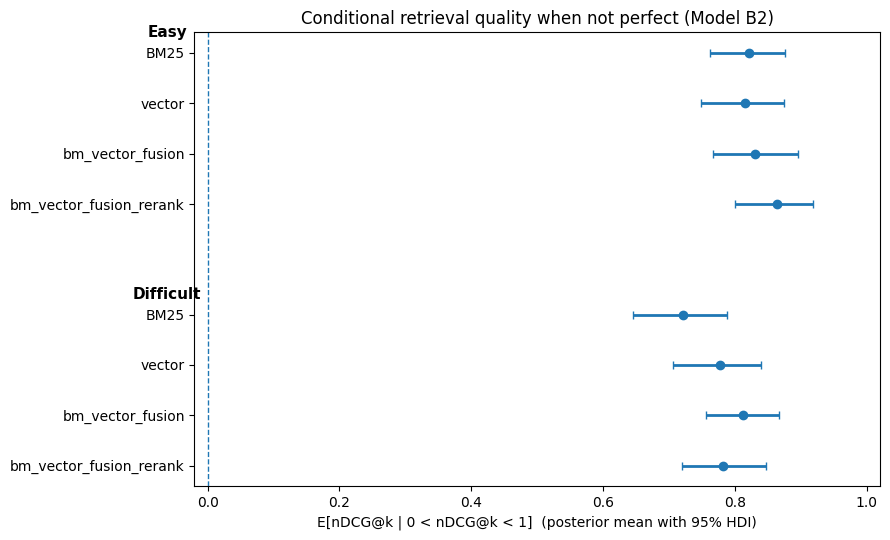

In [63]:
# -----------------------------
#  Forest plot for grid_b2_out (conditional mean given non-perfect)
# -----------------------------
import matplotlib.pyplot as plt

mode_order = ["BM25", "vector", "bm_vector_fusion", "bm_vector_fusion_rerank"]
diff_order = ["easy","difficult"]

dfp = grid_b2_out.copy()
dfp["Retrieval Mode"] = pd.Categorical(dfp["Retrieval Mode"], categories=mode_order, ordered=True)
dfp["Difficulty Level"] = pd.Categorical(dfp["Difficulty Level"], categories=diff_order, ordered=True)
dfp = dfp.sort_values(["Difficulty Level", "Retrieval Mode"]).reset_index(drop=True)

gap = 1.2
y = []
labels = []
block_centers = {}
pos = 0.0
for diff in diff_order:
    sub = dfp[dfp["Difficulty Level"] == diff]
    start = pos
    for _, r in sub.iterrows():
        y.append(pos)
        labels.append(r["Retrieval Mode"])
        pos += 1.0
    end = pos - 1.0
    block_centers[diff] = 0.5 * (start + end)
    pos += gap

y = np.array(y)

x = dfp["mu_mean"].to_numpy()
xlo = dfp["mu_hdi_low"].to_numpy()
xhi = dfp["mu_hdi_high"].to_numpy()
xerr = np.vstack([x - xlo, xhi - x])

plt.figure(figsize=(9, 5.5))
plt.errorbar(x=x, y=y, xerr=xerr, fmt="o", capsize=3, elinewidth=2, markersize=6)
plt.axvline(0.0, linestyle="--", linewidth=1)

# nDCG is in (0,1)
plt.xlim(-0.02, 1.02)
plt.yticks(y, labels)
plt.gca().invert_yaxis()

# Move difficulty labels slightly upward (as you preferred)
y_shift = -1.9
for diff, yc in block_centers.items():
    plt.text(
        -0.04, yc + y_shift, diff.capitalize(),
        transform=plt.gca().get_yaxis_transform(),
        va="center", ha="center",
        fontsize=11, fontweight="bold",
    )

plt.xlabel("E[nDCG@k | 0 < nDCG@k < 1]  (posterior mean with 95% HDI)")
plt.title("Conditional retrieval quality when not perfect (Model B2)")
plt.tight_layout()
plt.show()


In [64]:
# -----------------------------
# 4) Pairwise contrasts of conditional means (overall, averaged over difficulty)
#    Delta = 0.5 * [(mu_easy_A - mu_easy_B) + (mu_diff_A - mu_diff_B)]
# -----------------------------
from itertools import combinations

modes = grid_b2_out["Retrieval Mode"].unique().tolist()

def get_mu_draws(mode, diff):
    idx = grid_b2_out.index[
        (grid_b2_out["Retrieval Mode"] == mode) &
        (grid_b2_out["Difficulty Level"] == diff)
    ][0]
    return mu_g[idx, :]  # (S,)

rows = []
for a, b in combinations(modes, 2):
    delta = 0.5 * (
        (get_mu_draws(a, "easy") - get_mu_draws(b, "easy")) +
        (get_mu_draws(a, "difficult") - get_mu_draws(b, "difficult"))
    )
    h = az.hdi(delta, hdi_prob=0.95)
    rows.append({
        "A": a,
        "B": b,
        "Delta_mean (A-B)": float(delta.mean()),
        "HDI_low": float(h[0]),
        "HDI_high": float(h[1]),
        "P(A>B)": float((delta > 0).mean()),
    })

pairwise_b2_overall = pd.DataFrame(rows).sort_values("Delta_mean (A-B)", ascending=False)
pairwise_b2_overall


,A,B,Delta_mean (A-B),HDI_low,HDI_high,P(A>B)
5,bm_vector_fusion_rerank,vector,0.027104,-0.025380,0.084499,0.834500
4,bm_vector_fusion,vector,0.025418,-0.027582,0.079796,0.825125
3,bm_vector_fusion,bm_vector_fusion_rerank,-0.001686,-0.056037,0.051469,0.466500
2,BM25,vector,-0.024784,-0.081073,0.032435,0.194000
0,BM25,bm_vector_fusion,-0.050202,-0.103262,0.004887,0.035250
1,BM25,bm_vector_fusion_rerank,-0.051888,-0.104753,0.004963,0.034000


In [65]:
# -----------------------------
# 5) Pairwise contrasts within each difficulty (easy and difficult separately)
# -----------------------------
rows = []
for diff in ["easy", "difficult"]:
    for a, b in combinations(modes, 2):
        delta = get_mu_draws(a, diff) - get_mu_draws(b, diff)
        h = az.hdi(delta, hdi_prob=0.95)
        rows.append({
            "Difficulty": diff,
            "A": a,
            "B": b,
            "Delta_mean (A-B)": float(delta.mean()),
            "HDI_low": float(h[0]),
            "HDI_high": float(h[1]),
            "P(A>B)": float((delta > 0).mean()),
        })

pairwise_b2_by_diff = (
    pd.DataFrame(rows)
      .sort_values(["Difficulty", "Delta_mean (A-B)"], ascending=[True, False])
      .reset_index(drop=True)
)
pairwise_b2_by_diff


,Difficulty,A,B,Delta_mean (A-B),HDI_low,HDI_high,P(A>B)
0,difficult,bm_vector_fusion,vector,0.035835,-0.036546,0.109499,0.831000
1,difficult,bm_vector_fusion,bm_vector_fusion_rerank,0.030366,-0.039052,0.100910,0.801500
2,difficult,bm_vector_fusion_rerank,vector,0.005469,-0.073030,0.081413,0.557625
3,difficult,BM25,vector,-0.055541,-0.138449,0.021727,0.084375
4,difficult,BM25,bm_vector_fusion_rerank,-0.061010,-0.138763,0.016878,0.063250
5,difficult,BM25,bm_vector_fusion,-0.091376,-0.164389,-0.019452,0.006500
6,easy,bm_vector_fusion_rerank,vector,0.048738,-0.027473,0.126535,0.892750
7,easy,bm_vector_fusion,vector,0.015001,-0.061368,0.093855,0.644750
8,easy,BM25,vector,0.005973,-0.064645,0.078758,0.564125
9,easy,BM25,bm_vector_fusion,-0.009028,-0.078080,0.066973,0.405250
